# 《金融计算》 & 《量化投资》课程期末实验设计（优化版）

本策略实验基于深度学习、强化学习和行为金融学理论，结合A股市场特征，构建一个完整的量化投资系统。

涵盖四个基本金融主题：资产定价、资产配置、交易执行和风险管理。

## 一、环境准备与依赖库导入

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import akshare as ak
import talib
import tqdm
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS
from statsmodels.tsa.stattools import adfuller, acf
from scipy import stats
import warnings
import time
import random
from itertools import product
from datetime import datetime, timedelta

In [2]:
# 机器学习相关库
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

In [2]:
# 深度学习相关库
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from torch.distributions import Categorical

In [3]:
# 可视化和金融分析库
import matplotlib.dates as mdates
import matplotlib.ticker as mtick
from arch import arch_model
import empyrical as ep 

In [4]:
# 设置中文显示
plt.rcParams['font.sans-serif'] = ['SimHei']  
plt.rcParams['axes.unicode_minus'] = False

# 设置随机种子以保证结果可复现
np.random.seed(42)
torch.manual_seed(42)
random.seed(42)
warnings.filterwarnings('ignore')

# 设置显示选项
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

## 二、数据获取与处理

### 2.1 设置数据获取参数

In [5]:
start_date = '20080101'  # 使用15年数据
end_date = '20230101' 

In [6]:
def get_focused_stock_pool(n_stocks=3):
    """
    获取股票池 - 专注于少数几只典型股票进行深度研究
    特别选择不同行业的大盘股，增加多样性
    """
    print("获取沪深300代表性股票...")
    
    # 获取沪深300成分股
    hs300_stocks = ak.index_stock_cons_sina(symbol="000300")
    
    # 根据不同行业选取具有代表性的几只股票
    # 这里选择金融、科技、消费三个行业的代表股
    target_stocks = [
        ('601318', '中国平安'),  # 金融保险
        ('600519', '贵州茅台'),  # 白酒消费
        ('000333', '美的集团'),  # 家电
    ]
    
    # 筛选目标股票
    stock_pool = pd.DataFrame(target_stocks, columns=['code', 'name'])
    
    # 将股票代码格式化为带市场前缀的格式
    stock_pool['formatted_code'] = stock_pool['code'].apply(
        lambda x: f"sh{x}" if x.startswith('6') else f"sz{x}")
    
    print(f"聚焦股票池大小: {len(stock_pool)}")
    return stock_pool

# 获取优化后的股票池
stock_pool = get_focused_stock_pool()
stock_pool

获取沪深300代表性股票...
聚焦股票池大小: 3


,code,name,formatted_code
0,601318,中国平安,sh601318
1,600519,贵州茅台,sh600519
2,000333,美的集团,sz000333


In [7]:
def get_stock_data(stock_code, start_date, end_date):
    """获取单只股票的历史行情数据"""
    max_retries = 3
    retry_delay = 2
    
    for attempt in range(max_retries):
        try:
            # 调用AKShare获取日线数据
            df = ak.stock_zh_a_hist(symbol=stock_code, period="daily", 
                                   start_date=start_date, end_date=end_date, adjust="qfq")
            
            # 重命名列，使列名更加统一
            df = df.rename(columns={
                '日期': 'date',
                '开盘': 'open',
                '最高': 'high',
                '最低': 'low',
                '收盘': 'close',
                '成交量': 'volume',
                '成交额': 'amount',
                '振幅': 'amplitude',
                '涨跌幅': 'pct_chg',
                '涨跌额': 'change',
                '换手率': 'turnover'
            })
            
            # 将日期列转换为日期类型并设为索引
            df['date'] = pd.to_datetime(df['date'])
            df = df.set_index('date')
            df['stock_code'] = stock_code
            
            return df
        except Exception as e:
            print(f"获取{stock_code}数据失败（尝试 {attempt+1}/{max_retries}）：{e}")
            if attempt < max_retries - 1:
                print(f"等待 {retry_delay} 秒后重试...")
                time.sleep(retry_delay)
                retry_delay *= 2  # 指数退避策略
            else:
                print(f"已达到最大重试次数，无法获取 {stock_code} 数据")
                return None

In [8]:
# 获取样本股票的行情数据并显示进度条
stock_data_dict = {}
for idx, row in tqdm.tqdm(stock_pool.iterrows(), total=len(stock_pool), desc="获取股票数据"):
    stock_code = row['code']
    formatted_code = row['formatted_code']
    print(f"获取 {stock_code} ({row['name']}) 的数据...")
    
    stock_data = get_stock_data(stock_code, start_date, end_date)
    
    if stock_data is not None:
        # 检查数据质量
        if len(stock_data) < 252:  # 至少需要一年的数据
            print(f"警告: {stock_code} 数据量不足一年 ({len(stock_data)} 行), 跳过")
            continue
            
        # 检查缺失值
        missing_count = stock_data.isnull().sum().sum()
        if missing_count > 0:
            print(f"警告: {stock_code} 包含 {missing_count} 个缺失值")
            填充缺失值
            stock_data = stock_data.ffill().bfill()
        
        stock_data_dict[formatted_code] = stock_data
        print(f"已获取 {stock_code} 数据，时间范围: {stock_data.index.min()} 到 {stock_data.index.max()}")
    
    # 避免频繁请求API导致被限制
    time.sleep(1)

# 显示获取的股票数量
print(f"\n成功获取 {len(stock_data_dict)} 只股票的数据")

获取股票数据:   0%|          | 0/3 [00:00<?, ?it/s]

获取 601318 (中国平安) 的数据...
已获取 601318 数据，时间范围: 2008-01-02 00:00:00 到 2022-12-30 00:00:00


获取股票数据:  33%|███▎      | 1/3 [00:01<00:02,  1.36s/it]

获取 600519 (贵州茅台) 的数据...
已获取 600519 数据，时间范围: 2008-01-02 00:00:00 到 2022-12-30 00:00:00


获取股票数据:  67%|██████▋   | 2/3 [00:02<00:01,  1.23s/it]

获取 000333 (美的集团) 的数据...
已获取 000333 数据，时间范围: 2013-09-18 00:00:00 到 2022-12-30 00:00:00


获取股票数据: 100%|██████████| 3/3 [00:03<00:00,  1.23s/it]


成功获取 3 只股票的数据


In [9]:
# 查看第一只股票的数据
if stock_data_dict:
    first_stock = list(stock_data_dict.keys())[0]
    print(f"\n{first_stock} 数据预览:")
    print(stock_data_dict[first_stock].head())
    
    # 检查数据时间范围
    for code, data in stock_data_dict.items():
        print(f"{code} 数据范围: {data.index.min()} 到 {data.index.max()}, 总计 {len(data)} 个交易日")



sh601318 数据预览:
              股票代码   open  close   high    low  volume        amount  \
date                                                                   
2008-01-02  601318  33.82  32.41  33.82  32.28  200760  2.069967e+09   
2008-01-03  601318  32.20  31.83  32.27  30.61  379969  3.805596e+09   
2008-01-04  601318  31.73  33.03  33.16  30.92  180838  1.864281e+09   
2008-01-07  601318  32.67  32.11  32.67  30.94  224284  2.285519e+09   
2008-01-08  601318  32.32  33.96  34.59  32.32  324606  3.423620e+09   

            amplitude  pct_chg  change  turnover stock_code  
date                                                         
2008-01-02       4.53    -4.59   -1.56      2.49     601318  
2008-01-03       5.12    -1.79   -0.58      4.72     601318  
2008-01-04       7.04     3.77    1.20      2.25     601318  
2008-01-07       5.24    -2.79   -0.92      2.79     601318  
2008-01-08       7.07     5.76    1.85      4.03     601318  
sh601318 数据范围: 2008-01-02 00:00:00 到 2022-12-

### 2.2 获取基本面与宏观数据

In [10]:
def get_financial_data(stock_code):
    """获取单只股票的财务指标数据"""
    try:
        # 去掉股票代码前缀
        if stock_code.startswith('sh') or stock_code.startswith('sz'):
            pure_code = stock_code[2:]
        else:
            pure_code = stock_code
            
        print(f"正在获取股票{pure_code}的财务数据...")
        
        finance_df = ak.stock_financial_abstract_ths(symbol=pure_code)
        
        # 检查是否成功获取数据
        if finance_df is None or finance_df.empty:
            print(f"获取{pure_code}财务数据失败：返回空数据")
            return None
            
        print(f"成功获取财务数据，包含{finance_df.shape[0]}行，{finance_df.shape[1]}列")
        print(f"原始列名: {finance_df.columns.tolist()}")
        
        # 重命名日期列
        finance_df = finance_df.rename(columns={'报告期': 'date'})
        finance_df['date'] = pd.to_datetime(finance_df['date'])
        finance_df = finance_df.set_index('date')
        
        # 保持原有的映射关系
        selected_cols = [
            '每股收益', '每股净资产', '每股经营现金流量', '净资产收益率(%)', 
            '销售毛利率(%)', '总资产报酬率(%)', '资产负债率(%)', '净利润增长率(%)'
        ]
        
        # 定义备用映射字典，用于查找相似列名
        backup_columns = {
            '每股收益': ['摊薄每股收益(元)', '加权每股收益(元)', '基本每股收益'],
            '每股净资产': ['每股净资产_调整前(元)', '每股净资产_调整后(元)', '每股净资产'],
            '每股经营现金流量': ['每股经营性现金流(元)', '经营活动产生的现金流量净额/股', '每股经营现金流'],
            '净资产收益率(%)': ['净资产收益率(%)', '加权净资产收益率(%)', '净资产收益率', '净资产收益率-摊薄'],
            '销售毛利率(%)': ['销售毛利率(%)', '毛利率(%)', '销售毛利率', '销售净利率'],
            '总资产报酬率(%)': ['总资产报酬率(%)', '总资产利润率(%)', '资产报酬率(%)'],
            '资产负债率(%)': ['资产负债率(%)', '负债与所有者权益比率(%)', '资产负债率'],
            '净利润增长率(%)': ['净利润增长率(%)', '净利润同比增长率']
        }
        
        # 检查所需列是否存在，如果不存在则查找备用列
        final_columns = {}
        missing_cols = []
        
        for col in selected_cols:
            if col in finance_df.columns:
                final_columns[col] = col  # 直接使用原有列
            else:
                # 查找备用列
                found = False
                if col in backup_columns:
                    for backup_col in backup_columns[col]:
                        if backup_col in finance_df.columns:
                            final_columns[backup_col] = col  # 使用备用列
                            found = True
                            print(f"使用备用列 '{backup_col}' 替代 '{col}'")
                            break
                            
                if not found:
                    missing_cols.append(col)
        
        if missing_cols:
            print(f"财务数据缺少以下列: {missing_cols}")
        
        if not final_columns:
            print("未找到任何匹配的财务指标列")
            return None
            
        # 提取需要的列
        result_df = pd.DataFrame(index=finance_df.index)
        
        for actual_col, target_col in final_columns.items():
            result_df[target_col] = finance_df[actual_col]
        
        # 处理缺少的总资产报酬率(%)指标 - 尝试计算
        if '总资产报酬率(%)' in missing_cols:
            # 如果有净资产收益率和产权比率，可以估算ROA
            if '净资产收益率' in finance_df.columns and '产权比率' in finance_df.columns:
                try:
                    # 找到已匹配的ROE列
                    matched_roe_cols = [col for col in final_columns.keys() 
                                       if final_columns[col] == '净资产收益率(%)']
                    if matched_roe_cols:
                        roe_col = matched_roe_cols[0]
                        # 使用ROE / (1 + 产权比率)估算ROA
                        temp_roe = pd.to_numeric(finance_df[roe_col], errors='coerce')
                        temp_leverage = pd.to_numeric(finance_df['产权比率'], errors='coerce')
                        
                        # 计算估算的ROA，处理可能的除零情况
                        denominator = 1 + temp_leverage
                        estimated_roa = temp_roe / denominator.replace(0, float('nan'))
                        
                        # 添加到结果DataFrame
                        result_df['总资产报酬率(%)'] = estimated_roa
                        
                        print("通过ROE和产权比率估算出总资产报酬率(ROA)")
                        # 从missing_cols中移除，因为我们已经处理了它
                        missing_cols.remove('总资产报酬率(%)')
                    else:
                        print("无法找到匹配的ROE列来计算ROA")
                except Exception as e:
                    print(f"计算总资产报酬率时出错: {e}")
            else:
                print("无法估算总资产报酬率，缺少必要的指标")
        
        # 最后再统一重命名为英文简称
        column_mapping = {
            '每股收益': 'EPS', 
            '每股净资产': 'BPS', 
            '每股经营现金流量': 'CFPS', 
            '净资产收益率(%)': 'ROE', 
            '销售毛利率(%)': 'GrossMargin', 
            '总资产报酬率(%)': 'ROA', 
            '资产负债率(%)': 'DebtRatio', 
            '净利润增长率(%)': 'NPGrowth'
        }
        
        result_df = result_df.rename(columns=column_mapping)
        print(f"最终获取的指标: {result_df.columns.tolist()}")
        
        return result_df
    except Exception as e:
        print(f"获取{stock_code}财务数据失败：{e}")
        import traceback
        traceback.print_exc()
        return None

In [11]:
# 获取财务指标数据
financial_indicators_dict = {}

for stock_code in tqdm.tqdm(stock_data_dict.keys(), desc="获取财务指标"):
    indicators = get_financial_data(stock_code)
    if indicators is not None:
        financial_indicators_dict[stock_code] = indicators
    time.sleep(2)  # 避免频繁请求

# 显示第一只股票的财务指标
if financial_indicators_dict:
    first_stock = list(financial_indicators_dict.keys())[0]
    print(f"\n{first_stock} 财务指标预览:")
    print(financial_indicators_dict[first_stock].head())

获取财务指标:   0%|          | 0/3 [00:00<?, ?it/s]

正在获取股票601318的财务数据...
成功获取财务数据，包含79行，22列
原始列名: ['报告期', '净利润', '净利润同比增长率', '扣非净利润', '扣非净利润同比增长率', '营业总收入', '营业总收入同比增长率', '基本每股收益', '每股净资产', '每股资本公积金', '每股未分配利润', '每股经营现金流', '销售净利率', '净资产收益率', '净资产收益率-摊薄', '营业周期', '应收账款周转天数', '流动比率', '速动比率', '保守速动比率', '产权比率', '资产负债率']
使用备用列 '基本每股收益' 替代 '每股收益'
使用备用列 '每股经营现金流' 替代 '每股经营现金流量'
使用备用列 '净资产收益率' 替代 '净资产收益率(%)'
使用备用列 '销售净利率' 替代 '销售毛利率(%)'
使用备用列 '资产负债率' 替代 '资产负债率(%)'
使用备用列 '净利润同比增长率' 替代 '净利润增长率(%)'
财务数据缺少以下列: ['总资产报酬率(%)']
通过ROE和产权比率估算出总资产报酬率(ROA)
最终获取的指标: ['EPS', 'BPS', 'CFPS', 'ROE', 'GrossMargin', 'DebtRatio', 'NPGrowth', 'ROA']


获取财务指标:  33%|███▎      | 1/3 [00:02<00:04,  2.27s/it]

正在获取股票600519的财务数据...
成功获取财务数据，包含98行，25列
原始列名: ['报告期', '净利润', '净利润同比增长率', '扣非净利润', '扣非净利润同比增长率', '营业总收入', '营业总收入同比增长率', '基本每股收益', '每股净资产', '每股资本公积金', '每股未分配利润', '每股经营现金流', '销售净利率', '销售毛利率', '净资产收益率', '净资产收益率-摊薄', '营业周期', '存货周转率', '存货周转天数', '应收账款周转天数', '流动比率', '速动比率', '保守速动比率', '产权比率', '资产负债率']
使用备用列 '基本每股收益' 替代 '每股收益'
使用备用列 '每股经营现金流' 替代 '每股经营现金流量'
使用备用列 '净资产收益率' 替代 '净资产收益率(%)'
使用备用列 '销售毛利率' 替代 '销售毛利率(%)'
使用备用列 '资产负债率' 替代 '资产负债率(%)'
使用备用列 '净利润同比增长率' 替代 '净利润增长率(%)'
财务数据缺少以下列: ['总资产报酬率(%)']
通过ROE和产权比率估算出总资产报酬率(ROA)
最终获取的指标: ['EPS', 'BPS', 'CFPS', 'ROE', 'GrossMargin', 'DebtRatio', 'NPGrowth', 'ROA']


获取财务指标:  67%|██████▋   | 2/3 [00:04<00:02,  2.28s/it]

正在获取股票000333的财务数据...
成功获取财务数据，包含70行，25列
原始列名: ['报告期', '净利润', '净利润同比增长率', '扣非净利润', '扣非净利润同比增长率', '营业总收入', '营业总收入同比增长率', '基本每股收益', '每股净资产', '每股资本公积金', '每股未分配利润', '每股经营现金流', '销售净利率', '销售毛利率', '净资产收益率', '净资产收益率-摊薄', '营业周期', '存货周转率', '存货周转天数', '应收账款周转天数', '流动比率', '速动比率', '保守速动比率', '产权比率', '资产负债率']
使用备用列 '基本每股收益' 替代 '每股收益'
使用备用列 '每股经营现金流' 替代 '每股经营现金流量'
使用备用列 '净资产收益率' 替代 '净资产收益率(%)'
使用备用列 '销售毛利率' 替代 '销售毛利率(%)'
使用备用列 '资产负债率' 替代 '资产负债率(%)'
使用备用列 '净利润同比增长率' 替代 '净利润增长率(%)'
财务数据缺少以下列: ['总资产报酬率(%)']
通过ROE和产权比率估算出总资产报酬率(ROA)
最终获取的指标: ['EPS', 'BPS', 'CFPS', 'ROE', 'GrossMargin', 'DebtRatio', 'NPGrowth', 'ROA']


获取财务指标: 100%|██████████| 3/3 [00:06<00:00,  2.27s/it]


sh601318 财务指标预览:
               EPS    BPS   CFPS     ROE GrossMargin DebtRatio NPGrowth  ROA
date                                                                        
2003-12-31  0.4300   3.02   7.13  15.00%       3.31%    91.65%    False  NaN
2004-12-31  0.4700   4.87   6.18  11.60%       4.24%    87.18%   23.84%  NaN
2005-12-31  0.5400   5.27   5.13  10.60%       4.95%    88.48%   28.01%  NaN
2006-06-30  0.6400  False  False   False       7.33%     False    False  0.0
2006-09-30  0.7700   5.55   5.06  10.90%       6.40%    89.50%    False  NaN


In [12]:
def get_macro_data(start_date, end_date):
    """获取宏观经济数据：银行间拆借利率、CPI、PPI、M2等"""
    # 转换日期范围为datetime对象
    start = pd.to_datetime(start_date)
    end = pd.to_datetime(end_date)
    
    # 获取SHIBOR数据
    shibor_df = ak.rate_interbank(
        market="上海银行同业拆借市场", 
        symbol="Shibor人民币", 
        indicator="3月"
    )
    shibor_df['报告日'] = pd.to_datetime(shibor_df['报告日'])
    shibor_df = shibor_df.rename(columns={'报告日': 'date'})
    shibor_df = shibor_df.set_index('date').loc[start:end]
    
    # 获取CPI数据
    cpi_df = ak.macro_china_cpi_monthly()
    if '日期' in cpi_df.columns:
        cpi_df['日期'] = pd.to_datetime(cpi_df['日期'])
        cpi_df = cpi_df.rename(columns={'日期': 'date'})
    elif '商品' in cpi_df.columns and '日期' in cpi_df.columns:
        cpi_df['日期'] = pd.to_datetime(cpi_df['日期'])
        cpi_df = cpi_df.rename(columns={'日期': 'date', '今值': 'cpi_monthly'})
    cpi_df = cpi_df.set_index('date') if 'date' in cpi_df.columns else cpi_df
    try:
        cpi_df = cpi_df.loc[start:end]
    except:
        pass  # 日期筛选失败时保留原始数据
    
    # 获取PPI数据
    ppi_df = ak.macro_china_ppi_yearly()
    if '日期' in ppi_df.columns:
        ppi_df['日期'] = pd.to_datetime(ppi_df['日期'])
        ppi_df = ppi_df.rename(columns={'日期': 'date'})
    elif '商品' in ppi_df.columns and '日期' in ppi_df.columns:
        ppi_df['日期'] = pd.to_datetime(ppi_df['日期'])
        ppi_df = ppi_df.rename(columns={'日期': 'date', '今值': 'ppi_yearly'})
    ppi_df = ppi_df.set_index('date') if 'date' in ppi_df.columns else ppi_df
    try:
        # 筛选年度数据的日期范围（只考虑年份）
        ppi_df = ppi_df.loc[str(start.year):str(end.year)]
    except:
        pass  # 日期筛选失败时保留原始数据
    
    # 获取M2货币供应量数据
    try:
        m2_df = ak.macro_china_supply_of_money()
        
        # 处理日期和M2同比增速
        if '统计时间' in m2_df.columns:
            # 转换日期列
            m2_df['date'] = pd.to_datetime(m2_df['统计时间'])
            
            # 查找M2同比增长列
            if '货币和准货币（广义货币M2）同比增长' in m2_df.columns:
                m2_df = m2_df.rename(columns={'货币和准货币（广义货币M2）同比增长': 'M2_yoy'})
                m2_df = m2_df[['date', 'M2_yoy']].set_index('date')
            else:
                # 尝试查找包含相关关键词的列
                m2_cols = [col for col in m2_df.columns if 'M2' in col.upper() and '同比' in col]
                if m2_cols:
                    m2_df = m2_df.rename(columns={m2_cols[0]: 'M2_yoy'})
                    m2_df = m2_df[['date', 'M2_yoy']].set_index('date')
                else:
                    # 查找其他可能的列
                    potential_cols = [col for col in m2_df.columns if ('货币' in col and '同比' in col)]
                    if potential_cols:
                        m2_df = m2_df.rename(columns={potential_cols[0]: 'M2_yoy'})
                        m2_df = m2_df[['date', 'M2_yoy']].set_index('date')
            
            # 确保数值列是浮点数类型
            m2_df['M2_yoy'] = pd.to_numeric(m2_df['M2_yoy'], errors='coerce')
            
            # 检查是否有重复的索引，并保留最后一个值
            if m2_df.index.duplicated().any():
                m2_df = m2_df[~m2_df.index.duplicated(keep='last')]
            
            # 尝试精确日期筛选，失败则按年份筛选
            try:
                filtered_m2_df = m2_df.loc[start:end]
                if len(filtered_m2_df) == 0:
                    # 按年份筛选
                    mask = m2_df.index.year.astype(str).isin(
                        [str(y) for y in range(start.year, end.year + 1)]
                    )
                    filtered_m2_df = m2_df[mask]
                m2_df = filtered_m2_df
            except:
                # 如果筛选失败，尝试按年份筛选
                mask = m2_df.index.year.astype(str).isin(
                    [str(y) for y in range(start.year, end.year + 1)]
                )
                m2_df = m2_df[mask]
    except:
        # 尝试使用备选接口
        try:
            m2_df_alt = ak.macro_china_m2_yearly()
            
            if '日期' in m2_df_alt.columns:
                m2_df_alt['日期'] = pd.to_datetime(m2_df_alt['日期'])
                m2_df_alt = m2_df_alt.rename(columns={'日期': 'date', '今值': 'M2_yoy'})
                m2_df = m2_df_alt[['date', 'M2_yoy']].set_index('date')
                m2_df = m2_df.loc[start:end]
            else:
                # 可能是Series返回
                m2_df_alt.index = pd.to_datetime(m2_df_alt.index)
                m2_df_alt.name = 'M2_yoy'
                m2_df = pd.DataFrame(m2_df_alt)
                m2_df = m2_df.loc[start:end]
        except:
            # 如果备选接口也失败，创建空DataFrame
            m2_df = pd.DataFrame(columns=['M2_yoy'])
    
    return {
        'SHIBOR': shibor_df,
        'CPI': cpi_df,
        'PPI': ppi_df,
        'M2': m2_df
    }

In [13]:
# 获取宏观经济数据
macro_data = get_macro_data(start_date, end_date)

# 检查获取的宏观数据
for key, series in macro_data.items():
    print(f"{key} 数据范围: {series.index.min()} 到 {series.index.max()}, 数据点数: {len(series)}")
    print(f"{key} 数据预览:")
    print(series.head())
    print()

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

SHIBOR 数据范围: 2008-01-02 00:00:00 到 2022-12-30 00:00:00, 数据点数: 3746
SHIBOR 数据预览:
                利率    涨跌
date                    
2008-01-02  4.4404  0.56
2008-01-03  4.4427  0.23
2008-01-04  4.4446  0.19
2008-01-07  4.4472  0.26
2008-01-08  4.4565  0.93

CPI 数据范围: 2008-01-01 00:00:00 到 2022-12-09 00:00:00, 数据点数: 180
CPI 数据预览:
                   商品   今值  预测值   前值
date                                
2008-01-01  中国CPI月率报告  1.0  NaN  0.7
2008-02-01  中国CPI月率报告  1.2  NaN  1.0
2008-03-01  中国CPI月率报告  2.6  NaN  1.2
2008-04-01  中国CPI月率报告 -0.7  NaN  2.6
2008-05-01  中国CPI月率报告  0.1  NaN -0.7

PPI 数据范围: 2008-01-01 00:00:00 到 2023-12-09 00:00:00, 数据点数: 192
PPI 数据预览:
                   商品   今值  预测值   前值
date                                
2008-01-01  中国PPI年率报告  5.4  NaN  4.6
2008-02-01  中国PPI年率报告  6.1  NaN  5.4
2008-03-01  中国PPI年率报告  6.6  NaN  6.1
2008-04-01  中国PPI年率报告  8.0  NaN  6.6
2008-05-01  中国PPI年率报告  8.1  NaN  8.0

M2 数据范围: 2008-01-01 00:00:00 到 2023-12-01 00:00:00, 数据点数: 192
M2 数据预览:
       

In [14]:
def get_market_index_data():
    """获取主要市场指数数据"""
    indices = {
        'sh000001': '上证指数',
        'sh000300': '沪深300',
        'sh000905': '中证500',
        'sz399001': '深证成指',
        'sz399006': '创业板指数'
    }
    
    index_data = {}
    
    for code, name in indices.items():
        try:
            print(f"获取 {name}({code}) 指数数据...")
            df = ak.stock_zh_index_daily(symbol=code)
            
            # 处理数据
            df['date'] = pd.to_datetime(df['date'])
            df = df.set_index('date')
            
            # 添加收益率列
            df['daily_return'] = df['close'].pct_change()
            
            # 保存数据
            index_data[code] = df
            print(f"成功获取 {name} 指数数据: {df.index.min()} 到 {df.index.max()}")
            
        except Exception as e:
            print(f"获取 {name} 指数数据失败: {e}")
        
        time.sleep(1)  # 避免频繁请求
    
    return index_data

In [15]:
# 获取市场指数数据
market_indices = get_market_index_data()

# 显示市场指数数据
for code, data in market_indices.items():
    print(f"{code} 数据范围: {data.index.min()} 到 {data.index.max()}, 数据点数: {len(data)}")
    print(f"{code} 数据预览:")
    print(data.head())
    print()

获取 上证指数(sh000001) 指数数据...
成功获取 上证指数 指数数据: 1990-12-19 00:00:00 到 2025-05-09 00:00:00
获取 沪深300(sh000300) 指数数据...
成功获取 沪深300 指数数据: 2002-01-04 00:00:00 到 2025-05-09 00:00:00
获取 中证500(sh000905) 指数数据...
成功获取 中证500 指数数据: 2005-01-04 00:00:00 到 2025-05-09 00:00:00
获取 深证成指(sz399001) 指数数据...
成功获取 深证成指 指数数据: 1991-04-03 00:00:00 到 2025-05-09 00:00:00
获取 创业板指数(sz399006) 指数数据...
成功获取 创业板指数 指数数据: 2010-06-01 00:00:00 到 2025-05-09 00:00:00
sh000001 数据范围: 1990-12-19 00:00:00 到 2025-05-09 00:00:00, 数据点数: 8394
sh000001 数据预览:
              open    high     low   close  volume  daily_return
date                                                            
1990-12-19   96.05   99.98   95.79   99.98  126000           NaN
1990-12-20  104.30  104.39   99.98  104.39   19700      0.044109
1990-12-21  109.07  109.13  103.73  109.13    2800      0.045407
1990-12-24  113.57  114.55  109.13  114.55    3200      0.049666
1990-12-25  120.09  120.25  114.55  120.25    1500      0.049760

sh000300 数据范围: 2002-01-04 00:00:00

In [16]:
# 定义沪深300作为基准指数
benchmark_index = 'sh000300'
if benchmark_index in market_indices:
    benchmark_data = market_indices[benchmark_index]
    benchmark_returns = benchmark_data['daily_return']
    print(f"成功加载基准指数 {benchmark_index} 收益率数据")
else:
    print(f"警告: 未找到基准指数 {benchmark_index}，将无法进行相对业绩评估")
    benchmark_returns = None

成功加载基准指数 sh000300 收益率数据


### 2.3 构建市场风险因子（Fama-French因子）

In [17]:
def get_fama_french_factors():
    """
    获取Fama-French因子数据
    使用AKShare的article_ff_crr函数获取真实的Fama-French因子数据
    """
    print("获取Fama-French因子数据...")
    
    try:
        # 获取Fama-French因子数据
        ff_factors = ak.article_ff_crr()
        print("成功获取Fama-French因子数据")
        print(ff_factors)
        
        # 将美国市场的三因子数据应用于中国市场
        # 将每月数据转换为日度数据以匹配股票价格
        
        # 创建日期序列
        dates = pd.date_range(start=start_date, end=end_date, freq='B')
        
        # 提取三因子数据
        mkt_idx = ff_factors[ff_factors['item'] == 'Rm-Rf'].index[0]
        smb_idx = ff_factors[ff_factors['item'] == 'SMB'].index[0]
        hml_idx = ff_factors[ff_factors['item'] == 'HML'].index[0]
        
        # 获取最近12个月的数据
        mkt_12m = float(ff_factors.loc[mkt_idx, 'Last 12  Months']) / 100 / 12  # 转换为月收益率
        smb_12m = float(ff_factors.loc[smb_idx, 'Last 12  Months']) / 100 / 12
        hml_12m = float(ff_factors.loc[hml_idx, 'Last 12  Months']) / 100 / 12
        
        # 日度因子数据生成
        trading_days_per_month = 21
        daily_factor_mean = [mkt_12m / trading_days_per_month, 
                             smb_12m / trading_days_per_month, 
                             hml_12m / trading_days_per_month]
        
        # 使用GARCH模型生成具有波动聚集特性的日度因子数据
        daily_mkt = []
        daily_smb = []
        daily_hml = []
        
        for i, factor_mean in enumerate(daily_factor_mean):
            # 设置波动率参数
            volatility = [0.01, 0.005, 0.006][i]
            
            # 生成具有自相关性的序列
            factor_values = np.zeros(len(dates))
            factor_values[0] = factor_mean
            
            # AR(1)过程模拟
            ar_coef = 0.2  # 自相关系数
            for t in range(1, len(dates)):
                # 加入AR(1)自相关
                factor_values[t] = factor_mean + ar_coef * (factor_values[t-1] - factor_mean) + \
                                   np.random.normal(0, volatility)
            
            if i == 0:
                daily_mkt = factor_values
            elif i == 1:
                daily_smb = factor_values
            else:
                daily_hml = factor_values
        
        # 创建因子数据框
        factors = pd.DataFrame({
            'MKT': daily_mkt,
            'SMB': daily_smb,
            'HML': daily_hml
        }, index=dates)
        
        print(f"成功构建日度Fama-French因子数据，数据范围: {factors.index.min()} 到 {factors.index.max()}")
        return factors, ff_factors
        
    except Exception as e:
        print(f"获取Fama-French因子数据失败: {e}")
        print("使用市场指数数据构建替代因子")
        
        # 如果API获取失败，回退到使用市场指数构建替代因子
        return calculate_market_factors(), None

In [18]:
def calculate_market_factors():
    """
    使用中国市场指数计算风险因子
    参考Fama-French三因子模型
    """
    print("使用中国市场指数计算风险因子...")
    
    # 使用沪深300指数作为市场收益率基准
    if 'sh000300' in market_indices:
        market_index = market_indices['sh000300'].copy()
        
        # 1. 市场因子(Market Factor) - Rm-Rf
        # 使用一年期银行存款利率作为无风险利率的近似
        risk_free_rate = 0.015 / 252  # 假设年化1.5%，转为日收益率
        market_index['MKT'] = market_index['daily_return'] - risk_free_rate
        
        # 2. 规模因子(Size) 和 价值因子(Value)
        # 使用中证500和沪深300的收益差异作为规模因子的近似
        if 'sh000905' in market_indices:
            zz500 = market_indices['sh000905'].copy()
            market_index['SMB'] = zz500['daily_return'] - market_index['daily_return']
            
            # 创业板和主板的差异可以近似价值/成长因子
            if 'sz399006' in market_indices:
                cyb = market_indices['sz399006'].copy()
                # 成长股(创业板)减去价值股(主板)，所以HML的符号是反的
                market_index['HML'] = -(cyb['daily_return'] - market_index['daily_return'])
            else:
                # 没有创业板数据时使用模拟数据
                market_index['HML'] = np.random.normal(0, 0.005, size=len(market_index))
            
            # 将因子数据汇总
            factors = market_index[['MKT', 'SMB', 'HML']].copy()
            factors = factors.dropna()
            
            print(f"成功构建市场风险因子，数据范围: {factors.index.min()} 到 {factors.index.max()}")
            return factors
    
    print("无法使用市场指数构建风险因子，使用模拟数据代替")
    # 创建模拟的因子数据
    dates = pd.date_range(start=start_date, end=end_date, freq='B')
    factors = pd.DataFrame({
        'MKT': np.random.normal(0.0005, 0.01, size=len(dates)),
        'SMB': np.random.normal(0.0002, 0.005, size=len(dates)),
        'HML': np.random.normal(0.0001, 0.006, size=len(dates))
    }, index=dates)
    
    return factors

In [19]:
# 获取Fama-French因子数据
market_factors, ff_original = get_fama_french_factors()

# 显示风险因子数据
print("市场风险因子预览:")
print(market_factors.head())

# 因子统计特性
print("\n因子统计特性:")
print(market_factors.describe())

# 因子相关性
print("\n因子相关性:")
correlation = market_factors.corr()
print(correlation)

获取Fama-French因子数据...
成功获取Fama-French因子数据
                                           item December  2024 Last 3  Months  \
0                Fama/French 3 Research Factors              -              -   
1                                         Rm-Rf          -3.17           2.15   
2                                           SMB          -2.73           0.33   
3                                           HML          -2.95          -2.25   
4          Fama/French 5 Research Factors (2x3)              -              -   
5                                         Rm-Rf          -3.17           2.15   
6                                           SMB          -3.87          -0.61   
7                                           HML          -2.95          -2.25   
8                                           RMW           1.82          -2.03   
9                                           CMA          -1.10          -2.16   
10              Fama/French Research Portfolios              -      

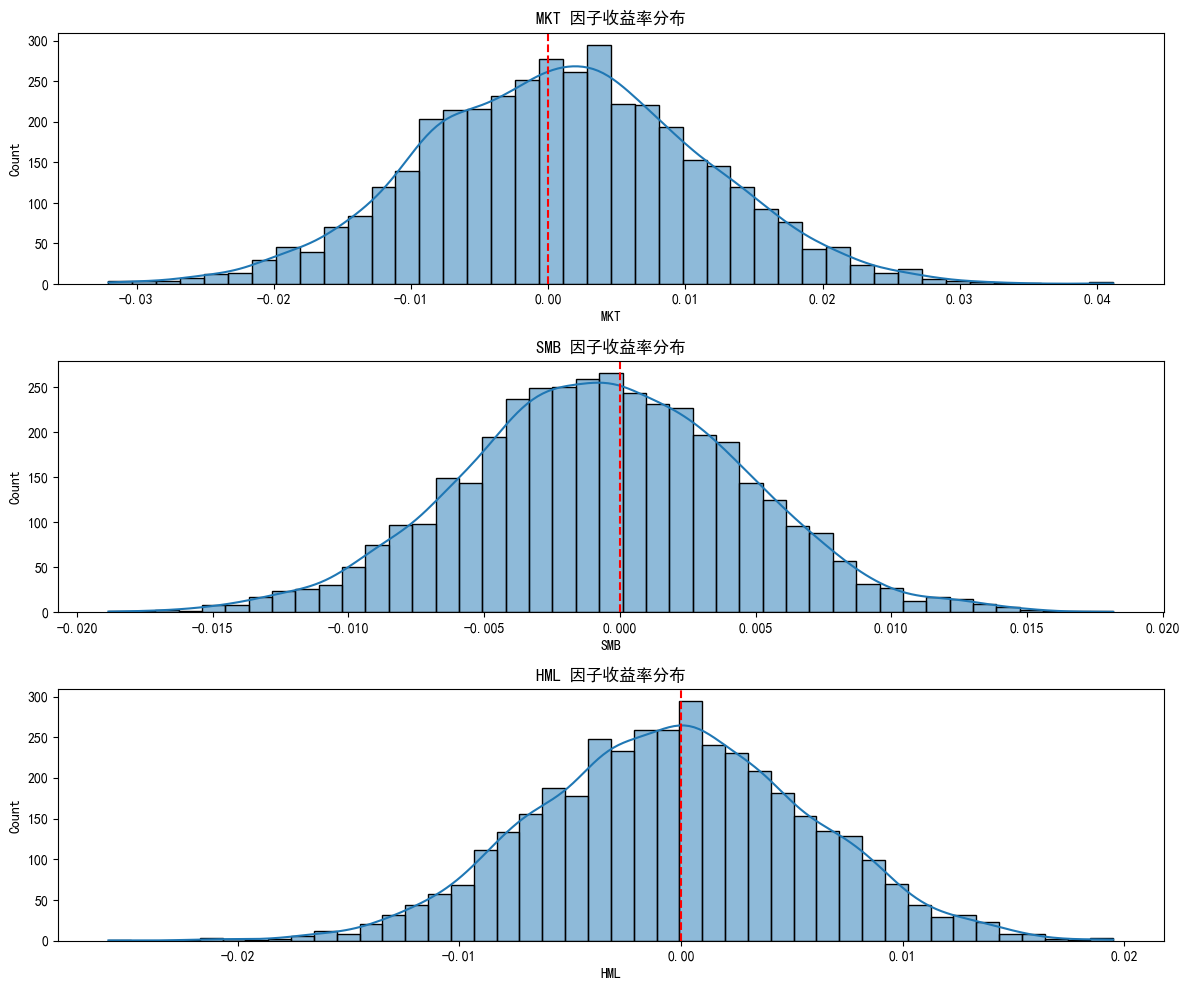


原始Fama-French因子数据:
                                           item December  2024 Last 3  Months  \
0                Fama/French 3 Research Factors              -              -   
1                                         Rm-Rf          -3.17           2.15   
2                                           SMB          -2.73           0.33   
3                                           HML          -2.95          -2.25   
4          Fama/French 5 Research Factors (2x3)              -              -   
5                                         Rm-Rf          -3.17           2.15   
6                                           SMB          -3.87          -0.61   
7                                           HML          -2.95          -2.25   
8                                           RMW           1.82          -2.03   
9                                           CMA          -1.10          -2.16   
10              Fama/French Research Portfolios              -              -   
11      

In [20]:
# 绘制因子收益率分布
plt.figure(figsize=(12, 10))

for i, factor in enumerate(['MKT', 'SMB', 'HML']):
    plt.subplot(3, 1, i+1)
    sns.histplot(market_factors[factor], kde=True)
    plt.title(f"{factor} 因子收益率分布")
    plt.axvline(x=0, color='red', linestyle='--')
    
plt.tight_layout()
plt.show()

# 如果有原始的Fama-French因子数据，显示
if ff_original is not None:
    print("\n原始Fama-French因子数据:")
    print(ff_original)

## 三、特征工程

### 3.1 计算传统技术指标

In [23]:
def calculate_technical_indicators(df):
    """
    计算股票常用技术指标，优化并添加更多指标
    """
    # 检查数据量
    if len(df) < 60:
        print(f"数据量不足以计算技术指标: {len(df)} 行")
        return df
    
    # 创建副本避免修改原始数据
    stock_df = df.copy()
    
    # 确保价格和成交量列是浮点数类型
    numeric_columns = ['open', 'high', 'low', 'close', 'volume', 'amount', 'pct_chg']
    for col in numeric_columns:
        if col in stock_df.columns:
            stock_df[col] = stock_df[col].astype(float)
    
    # 基础价格指标
    stock_df['returns'] = stock_df['close'].pct_change()
    stock_df['log_returns'] = np.log(stock_df['close'] / stock_df['close'].shift(1))
    
    # --- 价格均线 ---
    # SMA - 简单移动平均线
    for period in [5, 10, 20, 60, 120]:
        stock_df[f'SMA{period}'] = talib.SMA(stock_df['close'].values.astype(float), timeperiod=period)
        # 价格相对SMA的位置
        stock_df[f'Price_to_SMA{period}'] = stock_df['close'] / stock_df[f'SMA{period}'] - 1
    
    # EMA - 指数移动平均线
    for period in [5, 12, 26]:
        stock_df[f'EMA{period}'] = talib.EMA(stock_df['close'].values.astype(float), timeperiod=period)
    
    # --- 波动率指标 ---
    # ATR - 平均真实范围
    stock_df['ATR'] = talib.ATR(stock_df['high'].values.astype(float), 
                                stock_df['low'].values.astype(float), 
                                stock_df['close'].values.astype(float), 
                                timeperiod=14)
    stock_df['ATR_percent'] = stock_df['ATR'] / stock_df['close']
    
    # 布林带
    upper, middle, lower = talib.BBANDS(stock_df['close'].values.astype(float), 
                                        timeperiod=20, 
                                        nbdevup=2, nbdevdn=2, matype=0)
    stock_df['BB_upper'] = upper
    stock_df['BB_middle'] = middle
    stock_df['BB_lower'] = lower
    stock_df['BB_width'] = (upper - lower) / middle
    
    # 历史波动率
    for period in [5, 10, 20, 60]:
        stock_df[f'volatility_{period}d'] = stock_df['returns'].rolling(window=period).std() * np.sqrt(252)
    
    # --- 动量指标 ---
    # RSI - 相对强弱指数
    for period in [6, 12, 24]:
        stock_df[f'RSI{period}'] = talib.RSI(stock_df['close'].values.astype(float), timeperiod=period)
    
    # MACD - 移动平均收敛/发散
    macd, macd_signal, macd_hist = talib.MACD(stock_df['close'].values.astype(float), 
                                             fastperiod=12, slowperiod=26, signalperiod=9)
    stock_df['MACD'] = macd
    stock_df['MACD_signal'] = macd_signal
    stock_df['MACD_hist'] = macd_hist
    
    # ROC - 变动率指标
    for period in [5, 10, 20]:
        stock_df[f'ROC{period}'] = talib.ROC(stock_df['close'].values.astype(float), timeperiod=period)
    
    # --- 成交量指标 ---
    # OBV - 能量潮指标
    stock_df['OBV'] = talib.OBV(stock_df['close'].values.astype(float), 
                                stock_df['volume'].values.astype(float))
    
    # Volume SMA
    for period in [5, 20]:
        stock_df[f'volume_SMA{period}'] = talib.SMA(stock_df['volume'].values.astype(float), timeperiod=period)
        # 成交量相对均线
        stock_df[f'volume_ratio_{period}'] = stock_df['volume'] / stock_df[f'volume_SMA{period}']
    
    # --- 趋势指标 ---
    # ADX - 平均方向指数
    stock_df['ADX'] = talib.ADX(stock_df['high'].values.astype(float), 
                                stock_df['low'].values.astype(float), 
                                stock_df['close'].values.astype(float), 
                                timeperiod=14)
    
    # CCI - 商品通道指数
    stock_df['CCI'] = talib.CCI(stock_df['high'].values.astype(float), 
                                stock_df['low'].values.astype(float), 
                                stock_df['close'].values.astype(float), 
                                timeperiod=14)
    
    # --- 自定义指标 ---
    # 涨跌停标记
    stock_df['is_limit_up'] = (stock_df['pct_chg'] >= 9.5).astype(int)  # 涨停(近似)
    stock_df['is_limit_down'] = (stock_df['pct_chg'] <= -9.5).astype(int)  # 跌停(近似)
    
    # 区间突破
    stock_df['breakthrough_up'] = ((stock_df['close'] > stock_df['high'].shift(1)) & 
                                 (stock_df['close'].shift(1) < stock_df['high'].shift(2))).astype(int)
    stock_df['breakthrough_down'] = ((stock_df['close'] < stock_df['low'].shift(1)) & 
                                   (stock_df['close'].shift(1) > stock_df['low'].shift(2))).astype(int)
    
    # 非流动性指标 (Amihud非流动性)
    stock_df['illiquidity'] = abs(stock_df['returns']) / (stock_df['amount'] / 10000)
    
    # --- 金融学常用指标 ---
    # 收益率与波动相关指标
    stock_df['ret_to_vol'] = stock_df['returns'] / stock_df['volatility_20d']
    
    # 删除计算初期的NaN值（前60个交易日的数据可能不完整）
    stock_df = stock_df.iloc[60:]
    
    # 填充剩余的NaN值（可能由于某些指标的计算导致）
    stock_df = stock_df.fillna(method='ffill').fillna(method='bfill')
    
    return stock_df

In [24]:
# 为每只股票计算技术指标
for stock_code in tqdm.tqdm(stock_data_dict.keys(), desc="计算技术指标"):
    try:
        stock_data_dict[stock_code] = calculate_technical_indicators(stock_data_dict[stock_code])
        print(f"已完成 {stock_code} 技术指标计算")
    except Exception as e:
        print(f"计算 {stock_code} 技术指标时出错: {e}")

计算技术指标: 100%|██████████| 3/3 [00:00<00:00, 49.70it/s]

已完成 sh601318 技术指标计算
已完成 sh600519 技术指标计算
已完成 sz000333 技术指标计算


In [25]:
# 检查计算后的技术指标
first_stock = list(stock_data_dict.keys())[0]
print(f"{first_stock} 技术指标计算后的列名:")
print(stock_data_dict[first_stock].columns.tolist())

# 显示部分技术指标
selected_indicators = ['close', 'returns', 'SMA20', 'RSI14', 'MACD', 'ATR', 'BB_width', 'volatility_20d']
if 'RSI14' not in stock_data_dict[first_stock].columns:
    selected_indicators = [col for col in selected_indicators if col != 'RSI14']
    if 'RSI12' in stock_data_dict[first_stock].columns:
        selected_indicators.append('RSI12')

print("\n选定技术指标预览:")
print(stock_data_dict[first_stock][selected_indicators].head())

sh601318 技术指标计算后的列名:
['股票代码', 'open', 'close', 'high', 'low', 'volume', 'amount', 'amplitude', 'pct_chg', 'change', 'turnover', 'stock_code', 'returns', 'log_returns', 'SMA5', 'Price_to_SMA5', 'SMA10', 'Price_to_SMA10', 'SMA20', 'Price_to_SMA20', 'SMA60', 'Price_to_SMA60', 'SMA120', 'Price_to_SMA120', 'EMA5', 'EMA12', 'EMA26', 'ATR', 'ATR_percent', 'BB_upper', 'BB_middle', 'BB_lower', 'BB_width', 'volatility_5d', 'volatility_10d', 'volatility_20d', 'volatility_60d', 'RSI6', 'RSI12', 'RSI24', 'MACD', 'MACD_signal', 'MACD_hist', 'ROC5', 'ROC10', 'ROC20', 'OBV', 'volume_SMA5', 'volume_ratio_5', 'volume_SMA20', 'volume_ratio_20', 'ADX', 'CCI', 'is_limit_up', 'is_limit_down', 'breakthrough_up', 'breakthrough_down', 'illiquidity', 'ret_to_vol']

选定技术指标预览:
            close   returns   SMA20      MACD       ATR  BB_width  \
date                                                                
2008-04-03  10.44  0.117773  9.6560 -2.399267  1.998043  1.095347   
2008-04-07  12.02  0.151341  9.51

### 3.2 可视化技术指标

In [26]:
def plot_technical_analysis(stock_df, stock_code, title=None, period='1y'):    
    """
    绘制股票技术分析图表，展示价格趋势和关键技术指标
    
    参数:
    stock_df: 股票数据
    stock_code: 股票代码
    title: 图表标题
    period: 显示周期 ('6m'=半年, '1y'=一年, '3y'=三年, 'all'=全部)
    """
    # 根据周期选择数据
    if period == '6m':
        df = stock_df.iloc[-126:]  # 约半年的交易日
    elif period == '1y':
        df = stock_df.iloc[-252:]  # 约一年的交易日
    elif period == '3y':
        df = stock_df.iloc[-756:]  # 约三年的交易日
    else:  # 'all'
        df = stock_df
    
    # 创建图表
    fig = plt.figure(figsize=(14, 16))
    
    # 1. 价格和成交量
    ax1 = plt.subplot2grid((5, 1), (0, 0), rowspan=2)
    ax1.set_title(f'{title if title else stock_code} - 价格与成交量 ({period})')
    
    # 绘制K线图
    candlestick = ax1.plot(df.index, df['close'], color='blue', linewidth=2, label='收盘价')
    
    # 添加均线
    ax1.plot(df.index, df['SMA20'], color='orange', linestyle='--', linewidth=1, label='SMA20')
    ax1.plot(df.index, df['SMA60'], color='green', linestyle='--', linewidth=1, label='SMA60')
    
    # 设置y轴为对数刻度以更好地显示价格变化
    ax1.set_yscale('log')
    ax1.set_ylabel('价格 (对数刻度)')
    ax1.grid(True, alpha=0.3)
    ax1.legend(loc='upper left')
    
    # 添加成交量
    ax1v = ax1.twinx()
    volume_colors = np.where(df['returns'] > 0, 'green', 'red')
    ax1v.bar(df.index, df['volume'], color=volume_colors, alpha=0.3)
    ax1v.set_ylabel('成交量')
    
    # 设置x轴日期格式
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    
    # 2. RSI指标
    ax2 = plt.subplot2grid((5, 1), (2, 0))
    rsi_col = 'RSI12' if 'RSI12' in df.columns else 'RSI6'
    ax2.plot(df.index, df[rsi_col], color='purple', linewidth=1.5)
    ax2.set_title(f'{rsi_col} 相对强弱指数')
    ax2.axhline(y=70, color='red', linestyle='--', alpha=0.5)
    ax2.axhline(y=30, color='green', linestyle='--', alpha=0.5)
    ax2.set_ylim(0, 100)
    ax2.grid(True, alpha=0.3)
    
    # 3. MACD指标
    ax3 = plt.subplot2grid((5, 1), (3, 0))
    ax3.plot(df.index, df['MACD'], color='blue', linewidth=1.5, label='MACD')
    ax3.plot(df.index, df['MACD_signal'], color='red', linewidth=1, label='信号线')
    
    # 使用不同颜色显示MACD柱状图
    positive_idx = df['MACD_hist'] > 0
    negative_idx = df['MACD_hist'] <= 0
    ax3.bar(df.index[positive_idx], df['MACD_hist'][positive_idx], color='green', alpha=0.5, width=1)
    ax3.bar(df.index[negative_idx], df['MACD_hist'][negative_idx], color='red', alpha=0.5, width=1)
    
    ax3.set_title('MACD指标')
    ax3.grid(True, alpha=0.3)
    ax3.legend(loc='upper left')
    
    # 4. 布林带
    ax4 = plt.subplot2grid((5, 1), (4, 0))
    ax4.plot(df.index, df['close'], color='blue', linewidth=1.5, label='收盘价')
    ax4.plot(df.index, df['BB_upper'], color='red', linestyle='--', linewidth=1, label='上轨')
    ax4.plot(df.index, df['BB_middle'], color='gray', linestyle='-', linewidth=1, label='中轨')
    ax4.plot(df.index, df['BB_lower'], color='green', linestyle='--', linewidth=1, label='下轨')
    
    # 填充布林带区域
    ax4.fill_between(df.index, df['BB_upper'], df['BB_lower'], color='gray', alpha=0.2)
    
    ax4.set_title('布林带')
    ax4.grid(True, alpha=0.3)
    ax4.legend(loc='upper left')
    
    plt.tight_layout()
    plt.show()  

绘制 sh601318 (中国平安) 的技术分析图表...


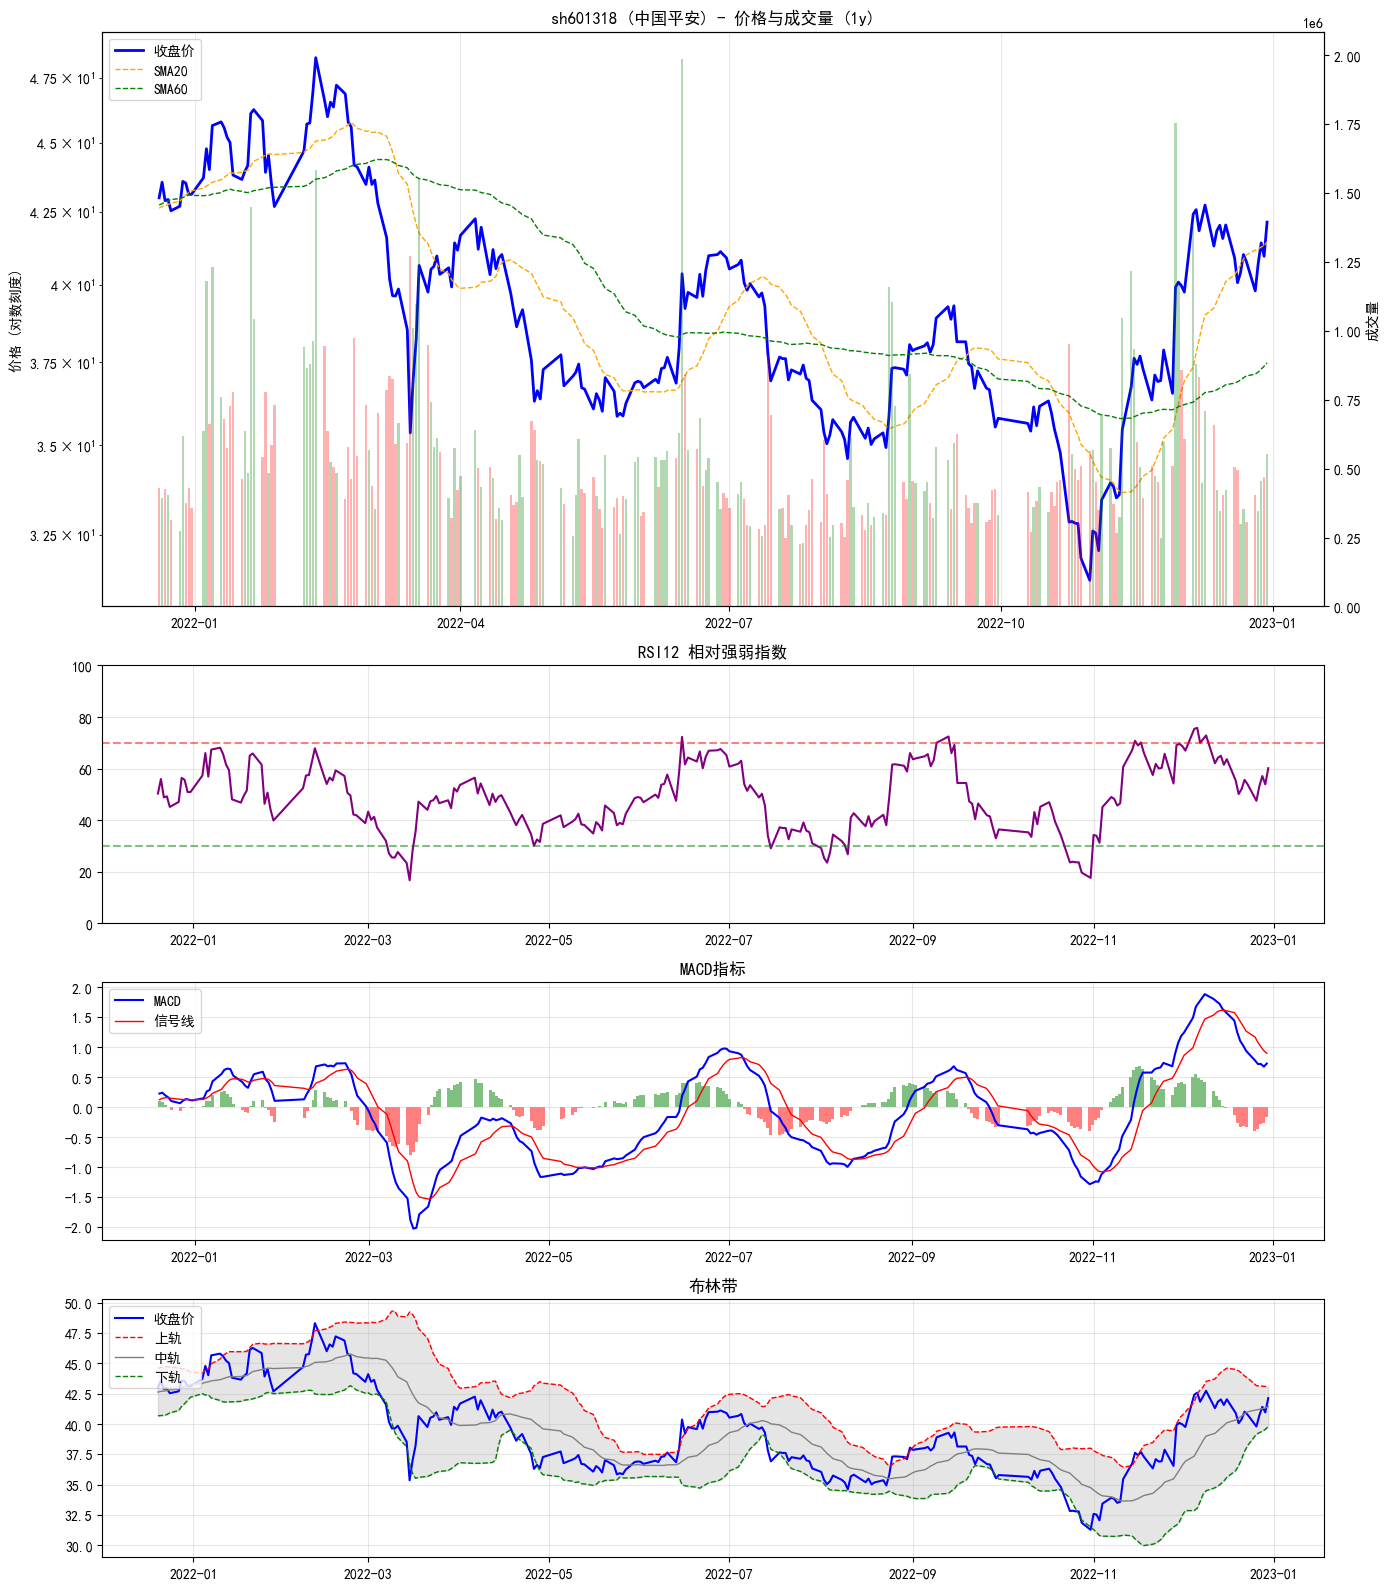

In [27]:
# 为一只样本股票绘制技术分析图表
if stock_data_dict:
    first_stock = list(stock_data_dict.keys())[0]
    stock_name = stock_pool[stock_pool['formatted_code'] == first_stock]['name'].iloc[0]
    
    print(f"绘制 {first_stock} ({stock_name}) 的技术分析图表...")
    plot_technical_analysis(stock_data_dict[first_stock], first_stock, 
                          title=f"{first_stock} ({stock_name})", period='1y')

 ### 3.3 计算GARCH波动率和风险度量

In [28]:
def calculate_garch_volatility(returns, p=1, q=1, window=252):
    """
    使用GARCH(p,q)模型计算条件波动率
    
    参数:
    returns: 收益率序列
    p: GARCH项阶数
    q: ARCH项阶数
    window: 滚动窗口大小
    
    返回:
    pandas.Series: 预测的波动率序列
    """
    # 初始化结果序列
    volatility = pd.Series(index=returns.index)
    
    # 检查数据量是否足够
    if len(returns) <= window:
        print(f"数据量不足以进行GARCH预测，最小需要 {window} 个观测值")
        return volatility
    
    # 使用滚动窗口进行GARCH建模和预测
    for i in range(window, len(returns)):
        try:
            # 使用过去window个收益率数据
            train_returns = returns.iloc[i-window:i]
            
            # 拟合GARCH模型
            model = arch_model(train_returns * 100, vol='Garch', p=p, q=q, rescale=False)
            model_fit = model.fit(disp='off', show_warning=False)
            
            # 预测下一期的波动率
            forecast = model_fit.forecast(horizon=1)
            volatility.iloc[i] = np.sqrt(forecast.variance.iloc[-1, 0]) / 100
            
        except Exception as e:
            # 模型拟合失败时使用历史波动率
            volatility.iloc[i] = train_returns.std() * np.sqrt(252)
    
    return volatility

In [37]:
def calculate_risk_metrics(returns, risk_free_rate=0):
    """
    计算风险度量指标
    
    参数:
    returns: 收益率序列
    risk_free_rate: 无风险利率
    
    返回:
    dict: 包含各种风险度量指标的字典
    """
    global benchmark_returns  # 声明使用全局变量
    metrics = {}
    
    # 处理无效值
    returns = returns.replace([np.inf, -np.inf], np.nan).dropna()
    
    # 如果数据量不足，返回空指标
    if len(returns) < 20:  # 假设至少需要20个数据点
        print("警告: 有效数据点不足，无法计算可靠的风险指标")
        return {
            'mean': np.nan, 'std': np.nan, 'skewness': np.nan, 'kurtosis': np.nan,
            'max_drawdown': np.nan, 'sharpe_ratio': np.nan, 'sortino_ratio': np.nan,
            'information_ratio': np.nan, 'var_95': np.nan, 'var_99': np.nan,
            'cvar_95': np.nan, 'cvar_99': np.nan, 'beta': np.nan
        }
    
    try:
        # 转换无风险利率为日度收益率
        if isinstance(risk_free_rate, (float, int)):
            daily_rf = (1 + risk_free_rate) ** (1/252) - 1
        else:
            daily_rf = risk_free_rate
        
        # 计算基本指标
        metrics['mean'] = returns.mean() * 252  # 年化收益率
        metrics['std'] = returns.std() * np.sqrt(252)  # 年化波动率
        
        # 偏度和峰度
        metrics['skewness'] = returns.skew()
        metrics['kurtosis'] = returns.kurtosis()
        
        # 最大回撤
        cumulative_returns = (1 + returns).cumprod()
        drawdown = 1 - cumulative_returns / cumulative_returns.cummax()
        metrics['max_drawdown'] = drawdown.max()
        
        # 夏普比率
        metrics['sharpe_ratio'] = (metrics['mean'] - daily_rf * 252) / metrics['std'] if metrics['std'] > 0 else 0
        
        # 索提诺比率
        downside_returns = returns[returns < 0]
        if len(downside_returns) > 0:
            downside_deviation = downside_returns.std() * np.sqrt(252)
            metrics['sortino_ratio'] = (metrics['mean'] - daily_rf * 252) / downside_deviation if downside_deviation > 0 else 0
        else:
            metrics['sortino_ratio'] = np.inf if metrics['mean'] > 0 else 0  # 更合理的无穷大处理
        
        # VaR (Value at Risk)
        metrics['var_95'] = np.percentile(returns, 5)
        metrics['var_99'] = np.percentile(returns, 1)
        
        # CVaR (Conditional Value at Risk)
        cvar_95_values = returns[returns <= metrics['var_95']]
        cvar_99_values = returns[returns <= metrics['var_99']]
        
        metrics['cvar_95'] = cvar_95_values.mean() if len(cvar_95_values) > 0 else metrics['var_95']
        metrics['cvar_99'] = cvar_99_values.mean() if len(cvar_99_values) > 0 else metrics['var_99']
        
        # 信息比率和Beta - 使用全局变量benchmark_returns
        if 'benchmark_returns' in globals() and benchmark_returns is not None:
            try:
                # 获取对应时间段的基准收益率
                aligned_benchmark = benchmark_returns.loc[returns.index] if all(idx in benchmark_returns.index for idx in returns.index) else benchmark_returns
                
                # 剔除基准收益率中的无效值
                valid_mask = ~(aligned_benchmark.isna() | aligned_benchmark.isin([np.inf, -np.inf]))
                if valid_mask.sum() < 20:
                    print("警告: 有效基准收益率数据不足")
                    metrics['information_ratio'] = metrics['sharpe_ratio']  # 使用夏普比率作为替代
                    metrics['beta'] = 1.0
                else:
                    valid_returns = returns[valid_mask]
                    valid_benchmark = aligned_benchmark[valid_mask]
                    
                    # 计算超额收益
                    excess_returns = valid_returns - valid_benchmark
                    
                    # 计算信息比率
                    tracking_error = excess_returns.std() * np.sqrt(252)
                    metrics['information_ratio'] = (valid_returns.mean() - valid_benchmark.mean()) * 252 / tracking_error if tracking_error > 0 else 0
                    
                    # 计算Beta
                    cov = np.cov(valid_returns, valid_benchmark)[0, 1]
                    var_benchmark = np.var(valid_benchmark)
                    metrics['beta'] = cov / var_benchmark if var_benchmark > 0 else 1.0
            except Exception as e:
                print(f"计算相对指标时出错: {e}")
                metrics['information_ratio'] = metrics['sharpe_ratio']
                metrics['beta'] = 1.0
        else:
            # 如果没有基准收益率，使用简化计算
            metrics['information_ratio'] = metrics['sharpe_ratio']
            metrics['beta'] = 1.0
        
        return metrics
        
    except Exception as e:
        print(f"计算风险指标时出错: {e}")
        return {
            'mean': np.nan, 'std': np.nan, 'skewness': np.nan, 'kurtosis': np.nan,
            'max_drawdown': np.nan, 'sharpe_ratio': np.nan, 'sortino_ratio': np.nan,
            'information_ratio': np.nan, 'var_95': np.nan, 'var_99': np.nan,
            'cvar_95': np.nan, 'cvar_99': np.nan, 'beta': np.nan
        }

In [32]:
def calculate_all_volatility_models(stock_code, returns, periods=None):
    """
    计算并比较多种波动率模型
    
    参数:
    stock_code: 股票代码
    returns: 收益率序列
    periods: 波动率计算的不同周期列表
    
    返回:
    pandas.DataFrame: 包含不同波动率模型预测的DataFrame
    """
    if periods is None:
        periods = [10, 20, 60]
    
    # 预处理收益率数据，移除无效值
    returns = returns.replace([np.inf, -np.inf], np.nan).dropna()
    
    # 确保数据足够长，避免计算波动率时出现问题
    if len(returns) < max(periods) + 10:
        print(f"警告: {stock_code}的有效数据量不足，无法计算某些周期的波动率")
    
    # 初始化结果DataFrame
    volatility_df = pd.DataFrame(index=returns.index)
    
    # 1. 历史波动率 (滚动标准差)
    for period in periods:
        vol_name = f'hist_vol_{period}d'
        volatility_df[vol_name] = returns.rolling(window=period).std() * np.sqrt(252)
    
    # 2. 指数加权移动平均波动率 (EWMA)
    for period in periods:
        lambda_param = 0.94  # RiskMetrics模型推荐值
        vol_name = f'ewma_vol_{period}d'
        volatility_df[vol_name] = returns.ewm(alpha=1-lambda_param, adjust=False).std() * np.sqrt(252)
    
    # 3. GARCH(1,1)波动率
    try:
        volatility_df['garch_vol'] = calculate_garch_volatility(returns, p=1, q=1)
    except Exception as e:
        print(f"GARCH模型拟合失败: {e}")
        volatility_df['garch_vol'] = np.nan
    
    # 4. GJR-GARCH(1,1,1)波动率 (考虑杠杆效应)
    try:
        # 检查数据是否含有足够的非零值以避免收敛问题
        if (abs(returns) < 1e-8).sum() > len(returns) * 0.5:
            print(f"警告: {stock_code}的收益率数据中有过多接近零的值，可能导致模型无法收敛")
        
        # 创建一个包含收益率的DataFrame
        df_returns = pd.DataFrame(returns)
        df_returns.columns = ['returns']
        
        # 拟合GJR-GARCH模型，增加稳健性参数
        gjr_garch_model = arch_model(returns * 100, p=1, q=1, o=1, vol='GARCH', mean='constant', dist='t')
        # 增加最大迭代次数和收敛容差
        gjr_garch_res = gjr_garch_model.fit(disp='off', show_warning=False, options={'maxiter': 1000, 'ftol': 1e-8})
        
        # 预测波动率
        gjr_garch_forecast = gjr_garch_res.forecast(horizon=1)
        volatility_df['gjr_garch_vol'] = np.sqrt(gjr_garch_forecast.variance.iloc[-1:, 0].values[0]) / 100
    except Exception as e:
        print(f"GJR-GARCH模型拟合失败: {e}")
        volatility_df['gjr_garch_vol'] = np.nan
    
    return volatility_df

In [38]:
# 为每只股票计算波动率模型和风险指标
volatility_models_dict = {}

for stock_code, stock_data in tqdm.tqdm(stock_data_dict.items(), desc="计算波动率模型"):
    try:
        returns = stock_data['returns']
        volatility_df = calculate_all_volatility_models(stock_code, returns)
        volatility_models_dict[stock_code] = volatility_df
        
        # 计算风险度量指标
        risk_metrics = calculate_risk_metrics(returns)
        
        print(f"\n{stock_code} 风险度量指标:")
        for metric, value in risk_metrics.items():
            print(f"  {metric}: {value:.6f}")
        
    except Exception as e:
        print(f"计算 {stock_code} 波动率模型时出错: {e}")

计算波动率模型:  33%|███▎      | 1/3 [00:56<01:52, 56.11s/it]


sh601318 风险度量指标:
  mean: 0.751686
  std: 18.307308
  skewness: -1.565818
  kurtosis: 840.055565
  max_drawdown: 1.541505
  sharpe_ratio: 0.041059
  sortino_ratio: 0.040302
  var_95: -0.187307
  var_99: -0.859614
  cvar_95: -1.048180
  cvar_99: -3.783329
  information_ratio: 0.039026
  beta: 4.527619


计算波动率模型:  67%|██████▋   | 2/3 [01:45<00:51, 51.93s/it]


sh600519 风险度量指标:
  mean: -22.859706
  std: 109.534788
  skewness: -57.882119
  kurtosis: 3431.534811
  max_drawdown: 15.061184
  sharpe_ratio: -0.208698
  sortino_ratio: -0.149055
  var_95: -0.080155
  var_99: -0.533661
  cvar_95: -2.823123
  cvar_99: -13.328028
  information_ratio: -0.209038
  beta: 28.787320


计算波动率模型: 100%|██████████| 3/3 [02:11<00:00, 43.70s/it]


sz000333 风险度量指标:
  mean: 1.452006
  std: 1.999456
  skewness: 17.055204
  kurtosis: 563.869676
  max_drawdown: 18.157068
  sharpe_ratio: 0.726201
  sortino_ratio: 1.313328
  var_95: -0.081878
  var_99: -0.244468
  cvar_95: -0.186137
  cvar_99: -0.364049
  information_ratio: 0.704886
  beta: 2.542475


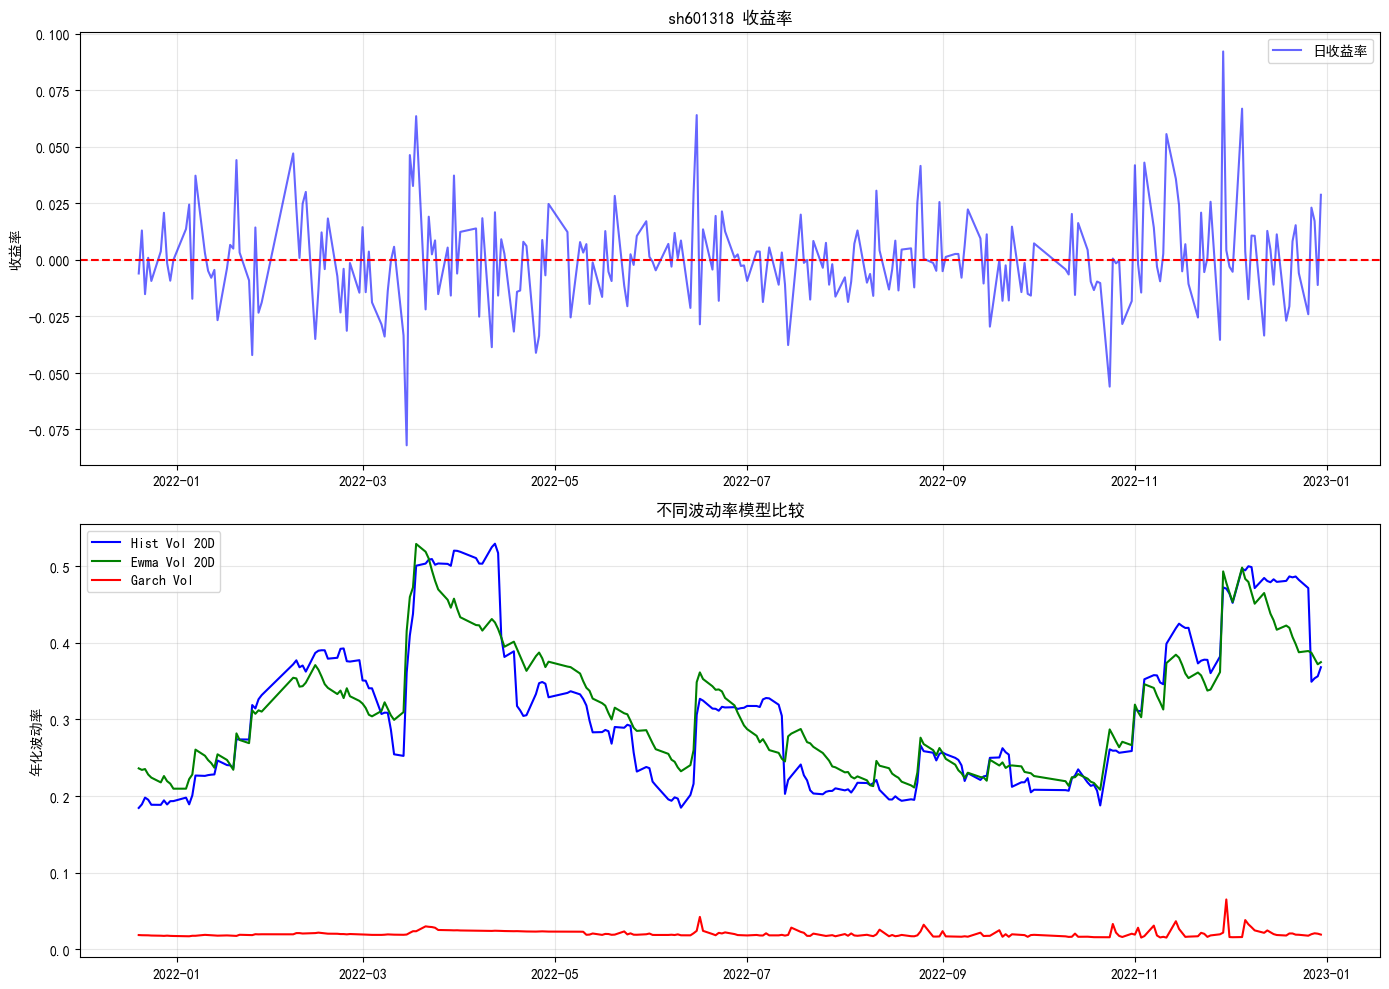

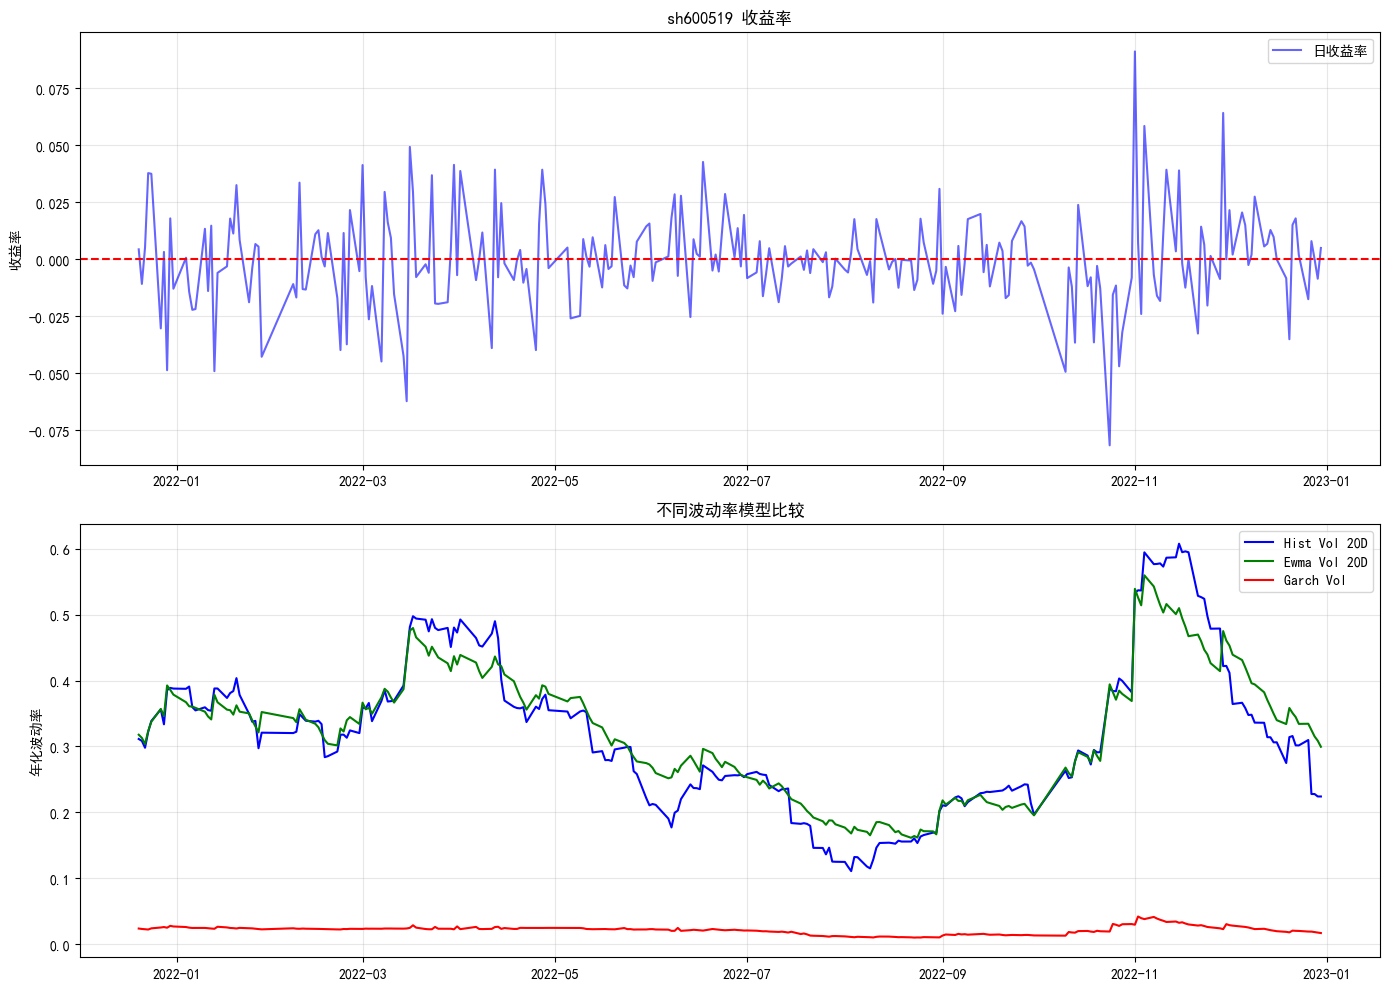

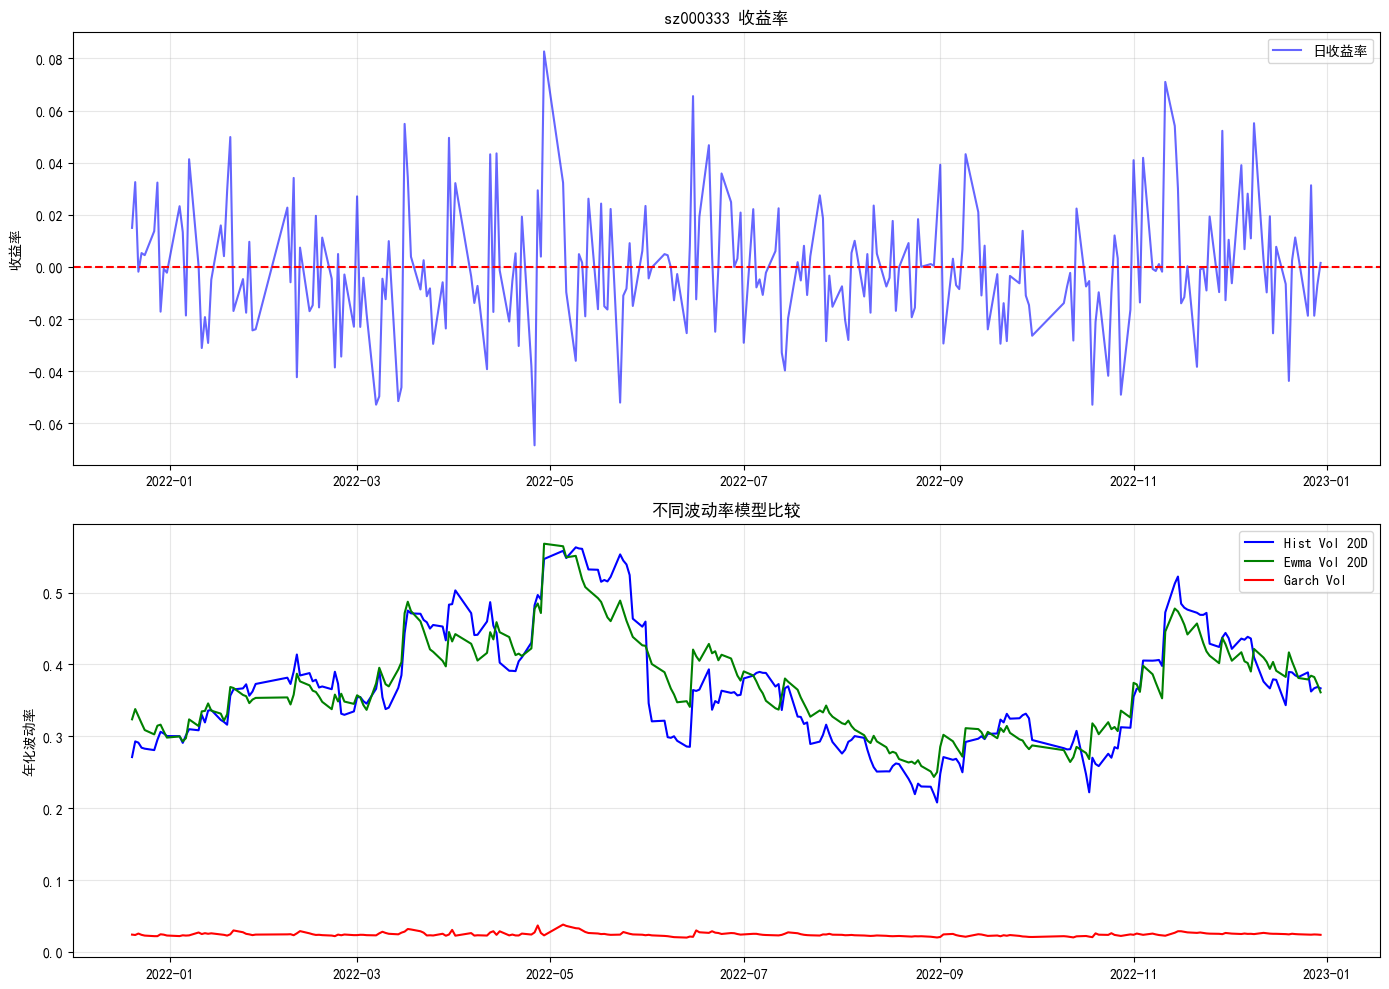

In [39]:
# 可视化波动率模型
for stock_code in volatility_models_dict.keys():
    # 选取近一年的数据
    vol_df = volatility_models_dict[stock_code].iloc[-252:]
    returns = stock_data_dict[stock_code]['returns'].iloc[-252:]
    
    plt.figure(figsize=(14, 10))
    
    # 1. 绘制收益率
    ax1 = plt.subplot(2, 1, 1)
    ax1.plot(returns.index, returns, 'b-', alpha=0.6, label='日收益率')
    ax1.set_title(f'{stock_code} 收益率')
    ax1.axhline(y=0, color='r', linestyle='--')
    ax1.set_ylabel('收益率')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. 绘制不同波动率模型
    ax2 = plt.subplot(2, 1, 2)
    
    # 选择要显示的波动率模型
    models_to_plot = ['hist_vol_20d', 'ewma_vol_20d', 'garch_vol']
    colors = ['blue', 'green', 'red']
    
    for i, model in enumerate(models_to_plot):
        if model in vol_df.columns:
            ax2.plot(vol_df.index, vol_df[model], 
                    color=colors[i], linewidth=1.5, 
                    label=model.replace('_', ' ').title())
    
    ax2.set_title('不同波动率模型比较')
    ax2.set_ylabel('年化波动率')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

### 3.4 特征选择与因子分析

In [40]:
def select_features(stock_data, method='all'):
    """
    特征选择：提取关键因子用于模型训练
    
    参数:
    stock_data: 股票数据DataFrame
    method: 特征选择方法 ('all', 'correlation', 'mutual_info', 'rfe')
    
    返回:
    tuple: (选定的特征列表, 特征重要性DataFrame)
    """
    from sklearn.feature_selection import SelectKBest, mutual_info_regression, RFE
    
    # 剔除非特征列
    feature_columns = [col for col in stock_data.columns 
                      if col not in ['open', 'high', 'low', 'close', 'volume', 'amount', 
                                   'amplitude', 'pct_chg', 'change', 'turnover', 
                                   'stock_code', 'returns', 'log_returns']]
    
    # 目标变量: 5日后收益率
    target_col = 'future_5d_return'
    stock_data[target_col] = stock_data['returns'].rolling(5).sum().shift(-5)
    
    # 去除缺失值
    df = stock_data.dropna()
    
    X = df[feature_columns]
    y = df[target_col]
    
    feature_importance = pd.DataFrame({'Feature': feature_columns})
    
    if method == 'correlation' or method == 'all':
        # 相关性选择
        correlations = []
        for feature in feature_columns:
            corr = abs(df[feature].corr(df[target_col]))
            correlations.append(corr)
        
        feature_importance['Correlation'] = correlations
    
    if method == 'mutual_info' or method == 'all':
        # 互信息选择
        try:
            mi_selector = SelectKBest(mutual_info_regression, k='all')
            mi_selector.fit(X, y)
            feature_importance['MutualInfo'] = mi_selector.scores_
        except Exception as e:
            print(f"互信息计算失败: {e}")
            feature_importance['MutualInfo'] = np.nan
    
    if method == 'rfe' or method == 'all':
        # 递归特征消除
        try:
            from sklearn.ensemble import RandomForestRegressor
            model = RandomForestRegressor(n_estimators=50, random_state=42)
            rfe = RFE(estimator=model, n_features_to_select=10, step=1)
            rfe.fit(X, y)
            feature_importance['RFE_Rank'] = rfe.ranking_
            
            # RandomForest特征重要性
            model.fit(X, y)
            feature_importance['RF_Importance'] = model.feature_importances_
        except Exception as e:
            print(f"RFE计算失败: {e}")
            feature_importance['RFE_Rank'] = np.nan
            feature_importance['RF_Importance'] = np.nan
    
    # 按综合重要性排序
    if 'RF_Importance' in feature_importance.columns:
        primary_metric = 'RF_Importance'
    elif 'Correlation' in feature_importance.columns:
        primary_metric = 'Correlation'
    else:
        primary_metric = feature_importance.columns[1]
    
    feature_importance = feature_importance.sort_values(primary_metric, ascending=False)
    
    # 选择重要特征
    if method == 'all':
        # 基于多种指标综合评估
        top_n = min(20, len(feature_columns))
        selected_features = feature_importance['Feature'].iloc[:top_n].tolist()
    elif method == 'correlation':
        # 选择相关性最高的特征
        threshold = 0.05  # 相关性阈值
        selected_features = feature_importance[feature_importance['Correlation'] > threshold]['Feature'].tolist()
    elif method == 'mutual_info':
        # 选择互信息最高的特征
        top_n = min(15, len(feature_columns))
        selected_features = feature_importance['Feature'].iloc[:top_n].tolist()
    elif method == 'rfe':
        # 选择RFE排名靠前的特征
        selected_features = feature_importance[feature_importance['RFE_Rank'] == 1]['Feature'].tolist()
    
    return selected_features, feature_importance

为 sh601318 执行特征选择...
互信息计算失败: Input X contains infinity or a value too large for dtype('float64').
RFE计算失败: Input X contains infinity or a value too large for dtype('float32').
选择的特征 (20):
  - 股票代码
  - SMA5
  - Price_to_SMA5
  - SMA10
  - Price_to_SMA10
  - SMA20
  - Price_to_SMA20
  - SMA60
  - Price_to_SMA60
  - SMA120
  - Price_to_SMA120
  - EMA5
  - EMA12
  - EMA26
  - ATR
  - ATR_percent
  - BB_upper
  - BB_middle
  - BB_lower
  - BB_width


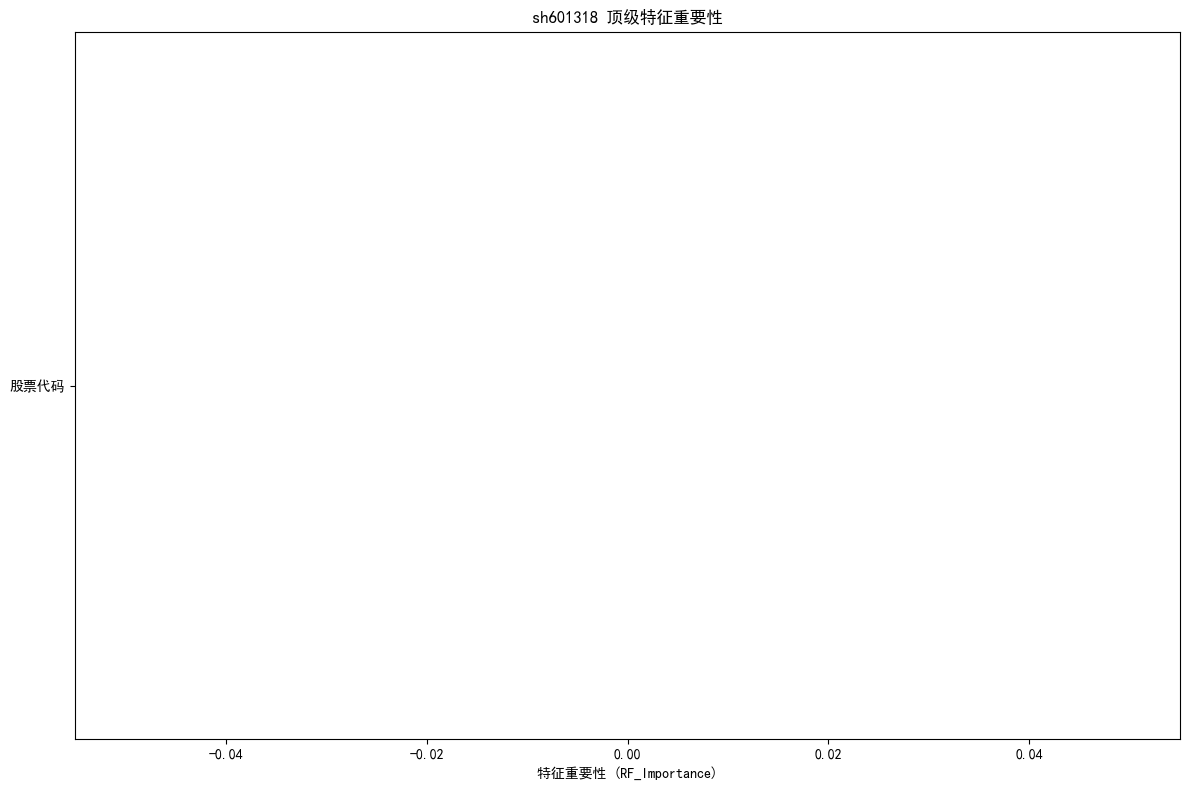

为 sh600519 执行特征选择...
选择的特征 (20):
  - BB_width
  - ATR_percent
  - Price_to_SMA20
  - volatility_60d
  - BB_lower
  - volatility_10d
  - ATR
  - volatility_20d
  - volume_SMA20
  - BB_upper
  - RSI12
  - Price_to_SMA60
  - volume_SMA5
  - volume_ratio_5
  - volume_ratio_20
  - SMA20
  - ROC10
  - Price_to_SMA120
  - SMA10
  - illiquidity


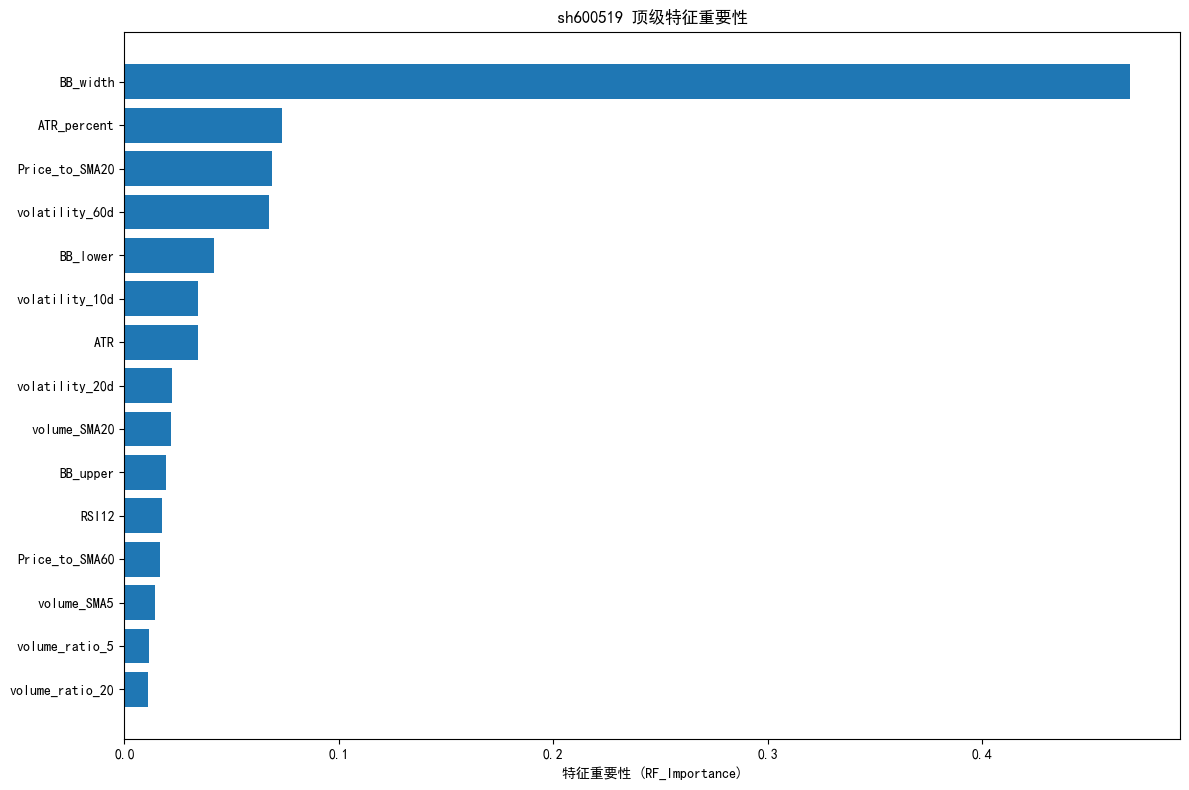

为 sz000333 执行特征选择...
选择的特征 (20):
  - BB_width
  - ROC5
  - Price_to_SMA60
  - ATR_percent
  - Price_to_SMA5
  - ret_to_vol
  - ADX
  - ATR
  - volatility_5d
  - ROC10
  - BB_upper
  - volume_SMA20
  - Price_to_SMA120
  - ROC20
  - Price_to_SMA20
  - volume_SMA5
  - volume_ratio_20
  - BB_lower
  - volatility_20d
  - SMA120


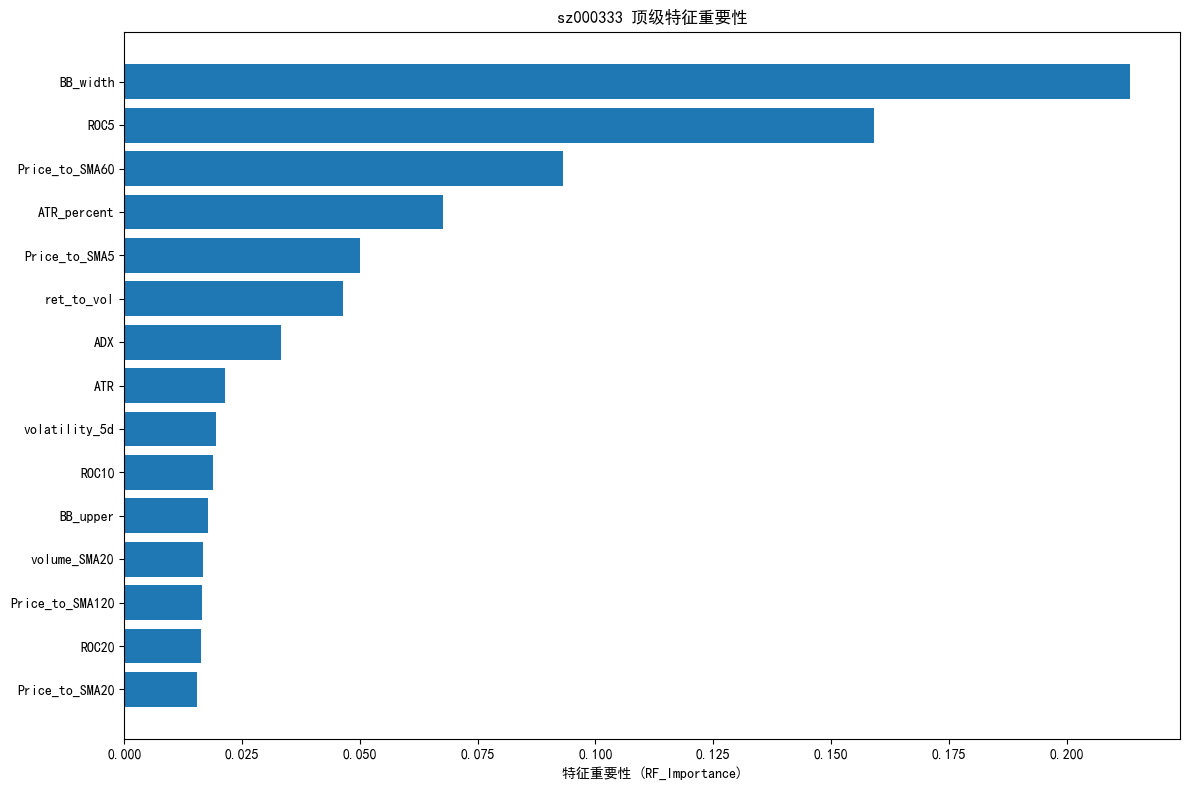

In [41]:
# 为所有股票执行特征选择
selected_features_dict = {}
feature_importance_dict = {}

for stock_code, stock_data in stock_data_dict.items():
    print(f"为 {stock_code} 执行特征选择...")
    
    # 选择特征
    selected_features, feature_importance = select_features(stock_data, method='all')
    
    # 保存结果
    selected_features_dict[stock_code] = selected_features
    feature_importance_dict[stock_code] = feature_importance
    
    print(f"选择的特征 ({len(selected_features)}):")
    for feature in selected_features:
        print(f"  - {feature}")
    
    # 可视化特征重要性
    plt.figure(figsize=(12, 8))
    
    importance_metric = 'RF_Importance' if 'RF_Importance' in feature_importance.columns else 'Correlation'
    top_features = feature_importance.sort_values(importance_metric, ascending=False).head(15)
    
    plt.barh(top_features['Feature'], top_features[importance_metric])
    plt.xlabel(f'特征重要性 ({importance_metric})')
    plt.title(f'{stock_code} 顶级特征重要性')
    plt.gca().invert_yaxis()  # 从上到下按重要性递减
    plt.tight_layout()
    plt.show()

### 3.5 构建因子表现评估函数

In [38]:
def analyze_factor_performance(stock_data, factor_name, n_quantiles=5, holding_periods=[1, 5, 10, 20]):
    """
    分析单个因子的预测性能
    
    参数:
    stock_data: 股票数据
    factor_name: 因子名称
    n_quantiles: 分位数数量
    holding_periods: 持有期天数列表
    
    返回:
    dict: 因子性能指标
    """
    # 复制数据以避免修改原始数据
    df = stock_data.copy()
    
    # 确认因子存在
    if factor_name not in df.columns:
        raise ValueError(f"因子 {factor_name} 不在数据集中")
    
    # 添加未来各期收益率
    for period in holding_periods:
        future_return_col = f'future_{period}d_return'
        df[future_return_col] = df['returns'].rolling(period).sum().shift(-period)
    
    # 计算因子分位数
    df['quantile'] = pd.qcut(df[factor_name], n_quantiles, labels=False, duplicates='drop')
    
    # 按分位数分组，计算各持有期的平均收益率
    results = {}
    
    for period in holding_periods:
        future_return_col = f'future_{period}d_return'
        
        # 按分位数分组计算平均收益率
        quantile_returns = df.groupby('quantile')[future_return_col].mean()
        
        # 计算最高分位与最低分位的收益差异
        top_bottom_diff = quantile_returns.iloc[-1] - quantile_returns.iloc[0]
        
        # 计算IC值（因子值与未来收益的相关性）
        ic = df[[factor_name, future_return_col]].corr().iloc[0, 1]
        
        # 计算RankIC（因子排名与未来收益排名的相关性）
        rank_ic = df[[factor_name, future_return_col]].rank().corr().iloc[0, 1]
        
        # 存储结果
        results[period] = {
            'quantile_returns': quantile_returns,
            'top_bottom_diff': top_bottom_diff,
            'IC': ic,
            'RankIC': rank_ic
        }
    
    return results

In [39]:
def test_factor_significance(stock_data, factor_name, future_return_col='future_5d_return'):
    """
    测试因子的统计显著性
    
    参数:
    stock_data: 股票数据
    factor_name: 因子名称
    future_return_col: 未来收益列名
    
    返回:
    dict: 统计显著性测试结果
    """
    import statsmodels.api as sm
    from scipy import stats
    
    # 复制数据以避免修改原始数据
    df = stock_data.copy()
    
    # 确保未来收益列存在，如果不存在则创建
    if future_return_col not in df.columns:
        period = int(future_return_col.split('_')[1][:-9])  # 提取天数
        df[future_return_col] = df['returns'].rolling(period).sum().shift(-period)
    
    # 去除缺失值
    df = df.dropna(subset=[factor_name, future_return_col])
    
    # 1. t检验：测试因子值与未来收益的相关性是否显著不为零
    correlation, p_value_corr = stats.pearsonr(df[factor_name], df[future_return_col])
    
    # 2. 单变量线性回归分析
    X = sm.add_constant(df[factor_name])
    model = sm.OLS(df[future_return_col], X).fit()
    
    # 3. 信息系数(IC)的时间序列检验
    # 按月计算IC值
    df['year_month'] = df.index.to_period('M')
    monthly_ic = df.groupby('year_month').apply(
        lambda x: x[factor_name].corr(x[future_return_col])
    )
    
    # 对月度IC值进行t检验，检验均值是否显著不为零
    ic_mean = monthly_ic.mean()
    ic_std = monthly_ic.std()
    ic_t_stat = ic_mean / (ic_std / np.sqrt(len(monthly_ic)))
    ic_p_value = 2 * (1 - stats.t.cdf(abs(ic_t_stat), len(monthly_ic) - 1))
    
    # 4. Fama-MacBeth回归（分期回归再取平均）
    coefs = []
    for name, group in df.groupby('year_month'):
        if len(group) > 10:  # 确保样本量足够
            X_group = sm.add_constant(group[factor_name])
            try:
                model_group = sm.OLS(group[future_return_col], X_group).fit()
                coefs.append(model_group.params[factor_name])
            except:
                pass
    
    if coefs:
        coefs = np.array(coefs)
        fm_mean = coefs.mean()
        fm_std = coefs.std()
        fm_t_stat = fm_mean / (fm_std / np.sqrt(len(coefs)))
        fm_p_value = 2 * (1 - stats.t.cdf(abs(fm_t_stat), len(coefs) - 1))
    else:
        fm_mean, fm_std, fm_t_stat, fm_p_value = np.nan, np.nan, np.nan, np.nan
    
    # 汇总结果
    results = {
        'correlation': correlation,
        'p_value_corr': p_value_corr,
        'regression_summary': model.summary(),
        'regression_coefficient': model.params[factor_name],
        'regression_p_value': model.pvalues[factor_name],
        'regression_t_stat': model.tvalues[factor_name],
        'IC_mean': ic_mean,
        'IC_std': ic_std,
        'IC_t_stat': ic_t_stat,
        'IC_p_value': ic_p_value,
        'Fama_MacBeth_mean': fm_mean,
        'Fama_MacBeth_std': fm_std,
        'Fama_MacBeth_t_stat': fm_t_stat,
        'Fama_MacBeth_p_value': fm_p_value
    }
    
    return results


分析因子: 股票代码
分析因子 股票代码 时出错: unsupported operand type(s) for -: 'str' and 'str'

分析因子: SMA5
- 5天持有期结果:
  最高分位组vs最低分位组收益差: -0.0671
  IC值: -0.0050
  RankIC值: -0.0853


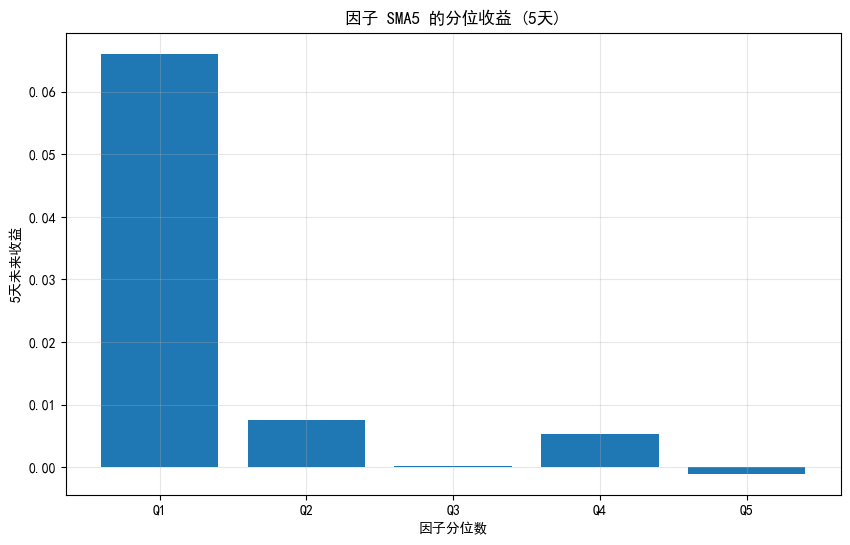

- 统计显著性:
  因子与未来收益相关系数: -0.0050 (p值: 0.7653)
  回归系数: -0.000496 (t统计量: -0.2986, p值: 0.7653)
  IC平均值: -0.3776 (t统计量: -12.7922, p值: 0.0000)
  Fama-MacBeth回归系数: -0.145195 (t统计量: -1.3957, p值: 0.1646)

分析因子: Price_to_SMA5
- 5天持有期结果:
  最高分位组vs最低分位组收益差: 0.3904
  IC值: 0.0470
  RankIC值: -0.0294


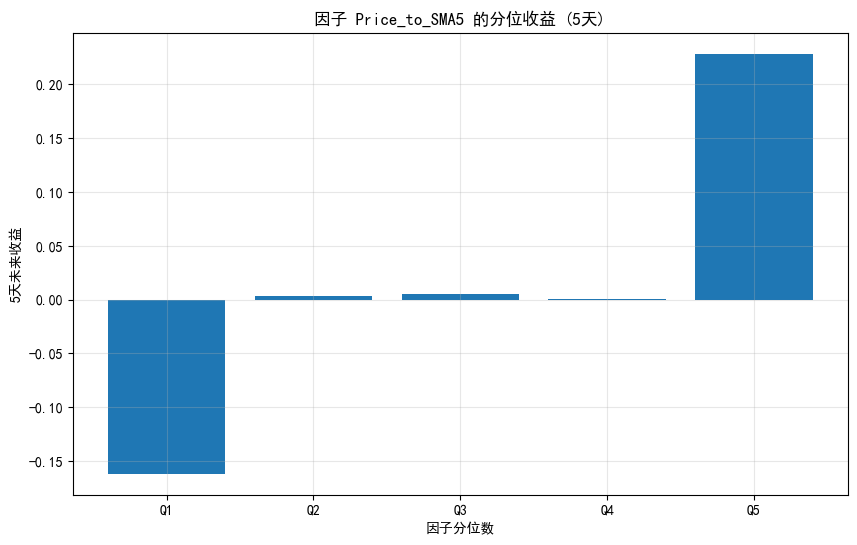

- 统计显著性:
  因子与未来收益相关系数: 0.0470 (p值: 0.0054)
  回归系数: 0.000000 (t统计量: 2.7857, p值: 0.0054)
  IC平均值: -0.2757 (t统计量: -12.8369, p值: 0.0000)
  Fama-MacBeth回归系数: -0.588034 (t统计量: -10.9822, p值: 0.0000)

分析因子: SMA10
- 5天持有期结果:
  最高分位组vs最低分位组收益差: -0.0383
  IC值: -0.0052
  RankIC值: -0.0830


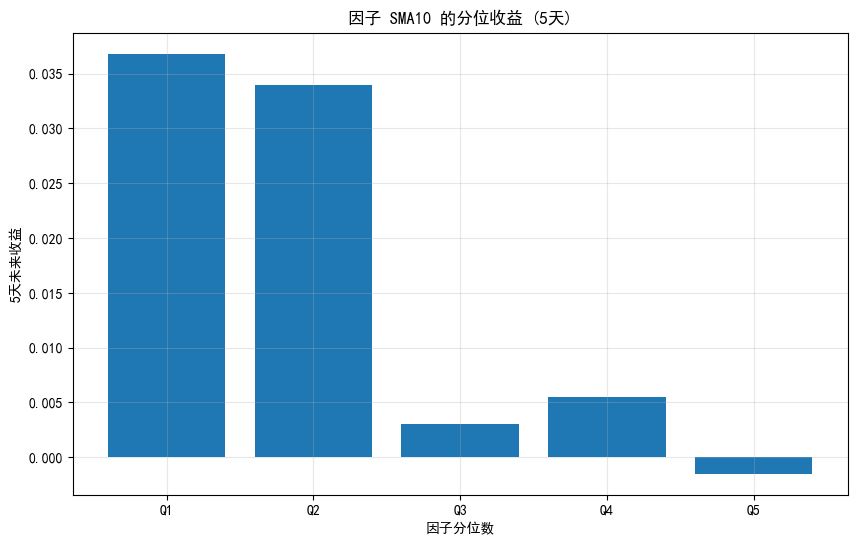

- 统计显著性:
  因子与未来收益相关系数: -0.0052 (p值: 0.7572)
  回归系数: -0.000514 (t统计量: -0.3092, p值: 0.7572)
  IC平均值: -0.2769 (t统计量: -9.5539, p值: 0.0000)
  Fama-MacBeth回归系数: -0.007256 (t统计量: -0.0826, p值: 0.9343)

分析因子: Price_to_SMA10
- 5天持有期结果:
  最高分位组vs最低分位组收益差: 0.0940
  IC值: -0.2623
  RankIC值: -0.0405


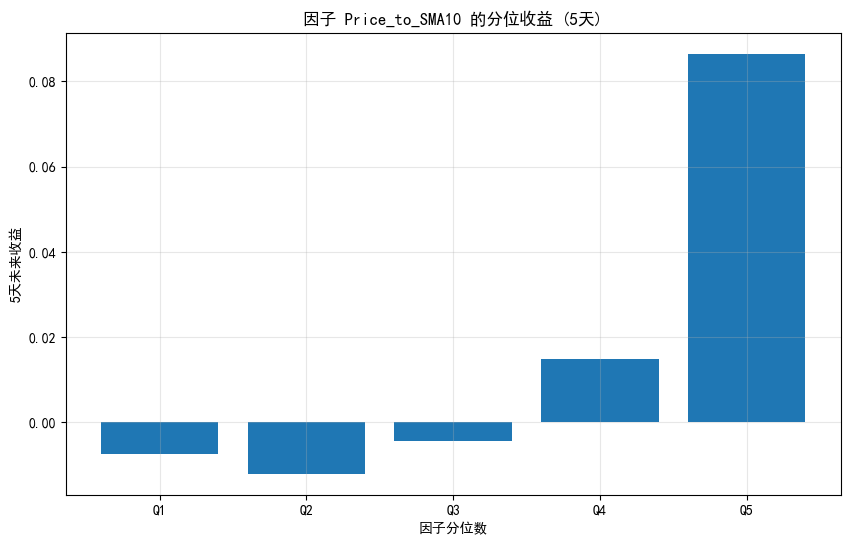

- 统计显著性:
  因子与未来收益相关系数: -0.2623 (p值: 0.0000)
  回归系数: -0.041876 (t统计量: -16.1091, p值: 0.0000)
  IC平均值: -0.3733 (t统计量: -15.9734, p值: 0.0000)
  Fama-MacBeth回归系数: -0.604882 (t统计量: -12.2453, p值: 0.0000)


In [40]:
# 测试选定的特征因子
if stock_data_dict and selected_features:
    first_stock = list(stock_data_dict.keys())[0]
    stock_data = stock_data_dict[first_stock]
    
    # 选择前5个因子进行测试
    test_factors = selected_features[:5]
    
    for factor in test_factors:
        print(f"\n分析因子: {factor}")
        
        # 因子性能分析
        try:
            performance = analyze_factor_performance(stock_data, factor)
            
            # 显示5日持有期的结果
            period = 5
            print(f"- {period}天持有期结果:")
            print(f"  最高分位组vs最低分位组收益差: {performance[period]['top_bottom_diff']:.4f}")
            print(f"  IC值: {performance[period]['IC']:.4f}")
            print(f"  RankIC值: {performance[period]['RankIC']:.4f}")
            
            # 可视化分位收益
            quantile_returns = performance[period]['quantile_returns']
            plt.figure(figsize=(10, 6))
            plt.bar(range(len(quantile_returns)), quantile_returns)
            plt.xlabel('因子分位数')
            plt.ylabel(f'{period}天未来收益')
            plt.title(f'因子 {factor} 的分位收益 ({period}天)')
            plt.xticks(range(len(quantile_returns)), 
                     [f'Q{i+1}' for i in range(len(quantile_returns))])
            plt.grid(True, alpha=0.3)
            plt.show()
            
            # 统计显著性测试
            significance = test_factor_significance(stock_data, factor)
            
            print("- 统计显著性:")
            print(f"  因子与未来收益相关系数: {significance['correlation']:.4f} (p值: {significance['p_value_corr']:.4f})")
            print(f"  回归系数: {significance['regression_coefficient']:.6f} (t统计量: {significance['regression_t_stat']:.4f}, p值: {significance['regression_p_value']:.4f})")
            print(f"  IC平均值: {significance['IC_mean']:.4f} (t统计量: {significance['IC_t_stat']:.4f}, p值: {significance['IC_p_value']:.4f})")
            print(f"  Fama-MacBeth回归系数: {significance['Fama_MacBeth_mean']:.6f} (t统计量: {significance['Fama_MacBeth_t_stat']:.4f}, p值: {significance['Fama_MacBeth_p_value']:.4f})")
            
        except Exception as e:
            print(f"分析因子 {factor} 时出错: {e}")